# DATA2 -  Random Frorests - baseline - A possible template for use in 3.1x notebooks

## Features:
1. 'AGE'
1. 'RAVLT\_immediate'
1. 'AVDEL30MIN\_neuro'
1. 'AVDELTOT\_neuro'
1. 'TRAASCOR\_neuro'
1. 'TRABSCOR\_neuro'
1. 'CATANIMSC\_neuro'
1. 'GDTOTAL\_gds'
1. 'ANARTERR\_neuro'
1. 'LRHHC\_n\_long'
1. 'Apoe4\_'
1. 'Gender\_num\_'
1. 'Subgroup\_'
1. 'Subgroup\_num\_'
1. 'Usage\_'

---

**Resources**
1. DATA
    1. [data/data2](https://github.com/MMIV-ML/MCI-subgroups/tree/master/data/data2) - csv files downloaded from ADNI,
    1. [data/data2_FS](https://github.com/MMIV-ML/MCI-subgroups/tree/master/data/data2_FS) - FS result csv files,
    1. [data_zip/20201109_data2_file_versions](https://github.com/MMIV-ML/MCI-subgroups/blob/master/data/data_zip/20201109_data2_file_versions.pdf) - download ADNI web page screen shoot taken for downaloaded csv files (some of file neames are printed with dates),
1. RESULTS
    1. [results/20210420](https://github.com/MMIV-ML/MCI-subgroups/tree/master/results/20210420) - result folder,
    1. [results/202100420/README.md](https://github.com/MMIV-ML/MCI-subgroups/blob/master/results/20210420/README.md) - short description,
1. GOOGLE DRIVE
    1. [slides](https://docs.google.com/presentation/d/1aEK7M5BPe0RxWYskzQCEDbT4Mf-4mRRqQ5uJ_YuqRzg/edit#slide=id.p) - link to google slides (**OUT OF DATE, MUST BE UPDATED !!!**),
    1. [GoogleDrive](https://drive.google.com/drive/folders/1r8l2R88-0T8Xahk30iAgjBCWXvV1R2J-) - the main google drive slide folder,
1. GIT HUB
    1. [GitHub](https://github.com/MMIV-ML/MCI-subgroups) - the main repo folder,
1. [An overview](https://github.com/MMIV-ML/MCI-subgroups/blob/master/results/20210420/3.xx_RF_bl_comparison.pdf)


The latest changes (ver. 0.11):

    -
    
   *Created: 2021.03.18 / Updated: 2021.05.05*
   
---

#### IMPORTS

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import eli5
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from pdpbox import pdp
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import display, SVG, Image
from eli5.sklearn import PermutationImportance

In [3]:
import mci_info as minfo
import mci_utils as mutils
import mci_freesurfer as mfs

In [4]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import plot_partial_dependence

#### GLOBAL VARIABLES

In [5]:
# Notebook folder
NB_DIR = %pwd
NB_DIR = Path(NB_DIR)
# Root MCI foler
ROOT_DIR = NB_DIR.parent
# Main data folder (with downloaded csv files)
MAIN_DATA_DIR = ROOT_DIR/'data/data2'
DATA_DIR_FS = ROOT_DIR / 'data/data2_FS'
# Current data dir with sMCI_cAD.csv & bl.csv files
CURRENT_DATA_DIR = ROOT_DIR/'results/20201110'
# Results folder
RESULTS_DIR = ROOT_DIR/'results/20210420' #misclassified patient table
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

#### INSTALLED PACKAGES INFO

In [6]:
if 1:
    packages = ['numpy', 'scipy', 'seaborn', 'pandas', 'matplotlib', 'statsmodels',
                'ipywidgets', 'eli5', 'pdpbox', 'sklearn']
    display(mutils.package_versions(installedOnly=False, theMostImportant=packages))



Computer name: mk-prec-7540
Operating system: Linux, 64bit

Python path: /home/marek/miniconda3/envs/py37/bin/python
Python version: 3.7.7 (default, Mar 26 2020, 15:48:22) 
[GCC 7.3.0]



module version
4          eli5  0.11.0
6    ipywidgets   7.6.2
10   matplotlib   3.3.4
12        numpy  1.19.2
14       pandas   1.1.5
15       pdpbox   0.2.1
19        scipy   1.5.2
20      seaborn  0.11.1
22      sklearn  0.24.1
23  statsmodels  0.11.1

---

##  SELECT VARIABLES TO FEED A MODEL - TO UPDATE IN EACH NOTEBOOK!!! 

In [7]:
# features = ['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 
#             'TRAASCOR_neuro', 'TRABSCOR_neuro', 'FAQ', 'APOE4', 'LRHHC_n_long',
#             'Subgroup_', 'Subgroup_num_', 'Usage_']


features = ['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro',
            'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro',
            'GDTOTAL_gds', 'ANARTERR_neuro', 'LRHHC_n_long',
            'Apoe4_','Gender_num_',  'Subgroup_', 'Subgroup_num_', 'Usage_']
#file_name_prefix = ‘3.14_mem3-exec3-anart-gds-bio2-dem2-apoe-feats’


# Filename prefixes used to save all results (tables, images, ...)
#file_name_prefix = '3.23_cog5-gen1-bio2-feats'
file_name_prefix = '3.19_template'
file_name_number = file_name_prefix.split('_')[0]

---

### LOAD BASE LINE FILE AND RESTRICT COLUMN RANGE TO SELECTED FEATURES ( + Subgroup\_ x2 + Usage\_) ONLY

In [8]:
bl_name = CURRENT_DATA_DIR / 'bl.csv'
bl_loaded = pd.read_csv(bl_name, index_col=0)

bl_sel_feat = bl_loaded[features]

print(f'Subjects: \t{bl_sel_feat.shape[0]}')
print(f'Columns: \t{bl_sel_feat.shape[1]}')

Subjects: 	708
Columns: 	15


#### DISPLAY THE NAN VALUES IN THE WHOLE DATA FRAME

In [9]:
print(bl_sel_feat.isnull().sum())
bl_sel_feat.shape

AGE                  0
RAVLT_immediate      0
AVDEL30MIN_neuro     0
AVDELTOT_neuro       1
TRAASCOR_neuro       0
TRABSCOR_neuro      10
CATANIMSC_neuro      0
GDTOTAL_gds          0
ANARTERR_neuro       6
LRHHC_n_long        14
Apoe4_               0
Gender_num_          0
Subgroup_            0
Subgroup_num_        0
Usage_               0
dtype: int64


(708, 15)

### SPLIT BETWEEN TRAIN AND TEST SUBSETS

In [10]:
bl_train = bl_sel_feat.loc[bl_sel_feat.Usage_ == 'train']
bl_test = bl_sel_feat.loc[bl_sel_feat.Usage_ == 'test']

# # backup of oryignal train data
# bl_train_copy = bl_train.copy(deep=True)

# a list of both sets, to ease forfurther manipulation
bl_sets = [['Train set', bl_train], ['Test set', bl_test]]

---

### TRAIN / TEST SETS SHORT INFO

In [11]:
print('Subjects in:')
for name, bl in bl_sets:
    print(f'\t{name}:\t{bl.shape[0]} ({bl.shape[0]/bl_sel_feat.shape[0] * 100:.0f}%)')

print('\n\nSubjects in each subgroup (with NaN included):\n')
for name, bl in bl_sets:
    print(f'*** {name} ***\n{bl.Subgroup_.value_counts().to_string()}\n')

Subjects in:
	Train set:	566 (80%)
	Test set:	142 (20%)


Subjects in each subgroup (with NaN included):

*** Train set ***
sMCI    305
cAD     261

*** Test set ***
sMCI    76
cAD     66



#### PRINT COLUMN NAMES IN IN BOTH SETS

In [12]:
minfo.included_feature_info(bl_train, pattern='adni-neuro-long-_')

Total number of columns: 15



adni (#2)        neuro (#6)     long (#1)      ours (#5)
0              AGE    ANARTERR_neuro  LRHHC_n_long         Apoe4_
1  RAVLT_immediate  AVDEL30MIN_neuro                  Gender_num_
2                     AVDELTOT_neuro                    Subgroup_
3                    CATANIMSC_neuro                Subgroup_num_
4                     TRAASCOR_neuro                       Usage_
5                     TRABSCOR_neuro

---

### COUNT NAN VALUES IN TRAIN AND TEST SETS

In [13]:
for name, bl in bl_sets:        
    print(f'*** NaN values in {name.upper()} set (out of {bl.shape[0]} rows) ***')
    print(bl.isnull().sum().to_string())
    print(f'\nRows in {name}: {bl.shape[0]}')
    print('\n\n')

*** NaN values in TRAIN SET set (out of 566 rows) ***
AGE                  0
RAVLT_immediate      0
AVDEL30MIN_neuro     0
AVDELTOT_neuro       1
TRAASCOR_neuro       0
TRABSCOR_neuro      10
CATANIMSC_neuro      0
GDTOTAL_gds          0
ANARTERR_neuro       4
LRHHC_n_long        13
Apoe4_               0
Gender_num_          0
Subgroup_            0
Subgroup_num_        0
Usage_               0

Rows in Train set: 566



*** NaN values in TEST SET set (out of 142 rows) ***
AGE                 0
RAVLT_immediate     0
AVDEL30MIN_neuro    0
AVDELTOT_neuro      0
TRAASCOR_neuro      0
TRABSCOR_neuro      0
CATANIMSC_neuro     0
GDTOTAL_gds         0
ANARTERR_neuro      2
LRHHC_n_long        1
Apoe4_              0
Gender_num_         0
Subgroup_           0
Subgroup_num_       0
Usage_              0

Rows in Test set: 142





### DISPLAY SUBJECTS WITH NaN ROWS IN BOTH SETS

In [14]:
for name, bl in bl_sets:
    num = bl.isnull().sum().sum()
    #idx = bl.isnull().index
    print(f'*** {name.upper()} ***')
    display(bl.loc[bl.isnull().any(axis=1)].head(num))
    print()

*** TRAIN SET ***


AGE  RAVLT_immediate  AVDEL30MIN_neuro  AVDELTOT_neuro  TRAASCOR_neuro  \
0     67.5             37.0               7.0            13.0            67.0   
20    83.3             21.0               0.0             7.0            34.0   
2284  69.0             29.0               1.0            11.0            54.0   
2948  61.7             21.0               0.0             6.0            57.0   
3367  65.5             20.0               4.0            12.0            26.0   
3437  75.2             27.0               3.0            10.0            22.0   
3523  81.6             28.0               3.0            10.0            61.0   
3547  76.6             33.0               8.0            14.0            40.0   
3639  66.7             55.0              11.0            14.0            33.0   
3652  71.0             20.0               0.0             8.0            60.0   
3855  76.6             38.0               7.0            15.0            39.0   
3883  56.3             53.0               9.0            15.0            30.0   
4133  68.9             47.0               8.0            11.0            23.0   
4153  86.4             17.0               2.0             7.0            72.0   
4484  69.4             38.0               5.0             9.0            49.0   
4713  71.9             42.0               4.0            15.0            28.0   
4814  76.8             39.0               7.0            14.0            30.0   
4913  71.3             44.0               0.0             NaN            28.0   
4930  68.1             54.0              13.0            15.0            27.0   
5077  77.6             26.0               3.0             7.0            53.0   
5353  79.3             25.0               0.0             3.0            38.0   
5530  65.4             34.0               2.0            15.0            41.0   
5831  71.9             28.0               5.0            11.0            36.0   
5855  85.3             24.0               3.0             8.0            72.0   
5978  55.0             42.0               7.0            13.0            23.0   
6111  75.3             18.0               0.0            13.0            56.0   
6140  69.0             29.0               0.0             4.0            27.0   

      TRABSCOR_neuro  CATANIMSC_neuro  GDTOTAL_gds  ANARTERR_neuro  \
0              271.0             22.0          3.0             NaN   
20               NaN             16.0          2.0             2.0   
2284             NaN             11.0          5.0            34.0   
2948             NaN             10.0          2.0            25.0   
3367            75.0             14.0          1.0             NaN   
3437           112.0             22.0          0.0            14.0   
3523           170.0             14.0          0.0            24.0   
3547             NaN             13.0          3.0             3.0   
3639             NaN             28.0          3.0             1.0   
3652           176.0             20.0          1.0            24.0   
3855            82.0             13.0          1.0             NaN   
3883             NaN             24.0          4.0            20.0   
4133            50.0             17.0          2.0            26.0   
4153           300.0              5.0          5.0            38.0   
4484             NaN             18.0          1.0             5.0   
4713            91.0             20.0          1.0             3.0   
4814             NaN             22.0          3.0            27.0   
4913            45.0             20.0          1.0             2.0   
4930            65.0             17.0          0.0             4.0   
5077           180.0             23.0          5.0            27.0   
5353           120.0             17.0          4.0            14.0   
5530            67.0             11.0          3.0            14.0   
5831             NaN             21.0          0.0             6.0   
5855           298.0             11.0          2.0        


*** TEST SET ***


AGE  RAVLT_immediate  AVDEL30MIN_neuro  AVDELTOT_neuro  TRAASCOR_neuro  \
3926  63.0             32.0               5.0            15.0            35.0   
6291  71.5             34.0               7.0            13.0            50.0   
6304  80.2             25.0               0.0            10.0            31.0   

      TRABSCOR_neuro  CATANIMSC_neuro  GDTOTAL_gds  ANARTERR_neuro  \
3926           105.0             21.0          2.0             7.0   
6291           127.0             16.0          1.0             NaN   
6304            73.0              8.0          1.0             NaN   

      LRHHC_n_long  Apoe4_  Gender_num_ Subgroup_  Subgroup_num_ Usage_  
3926           NaN     1.0            0      sMCI              0   test  
6291      0.004996     0.0            0      sMCI              0   test  
6304      0.003878     0.0            1       cAD              1   test

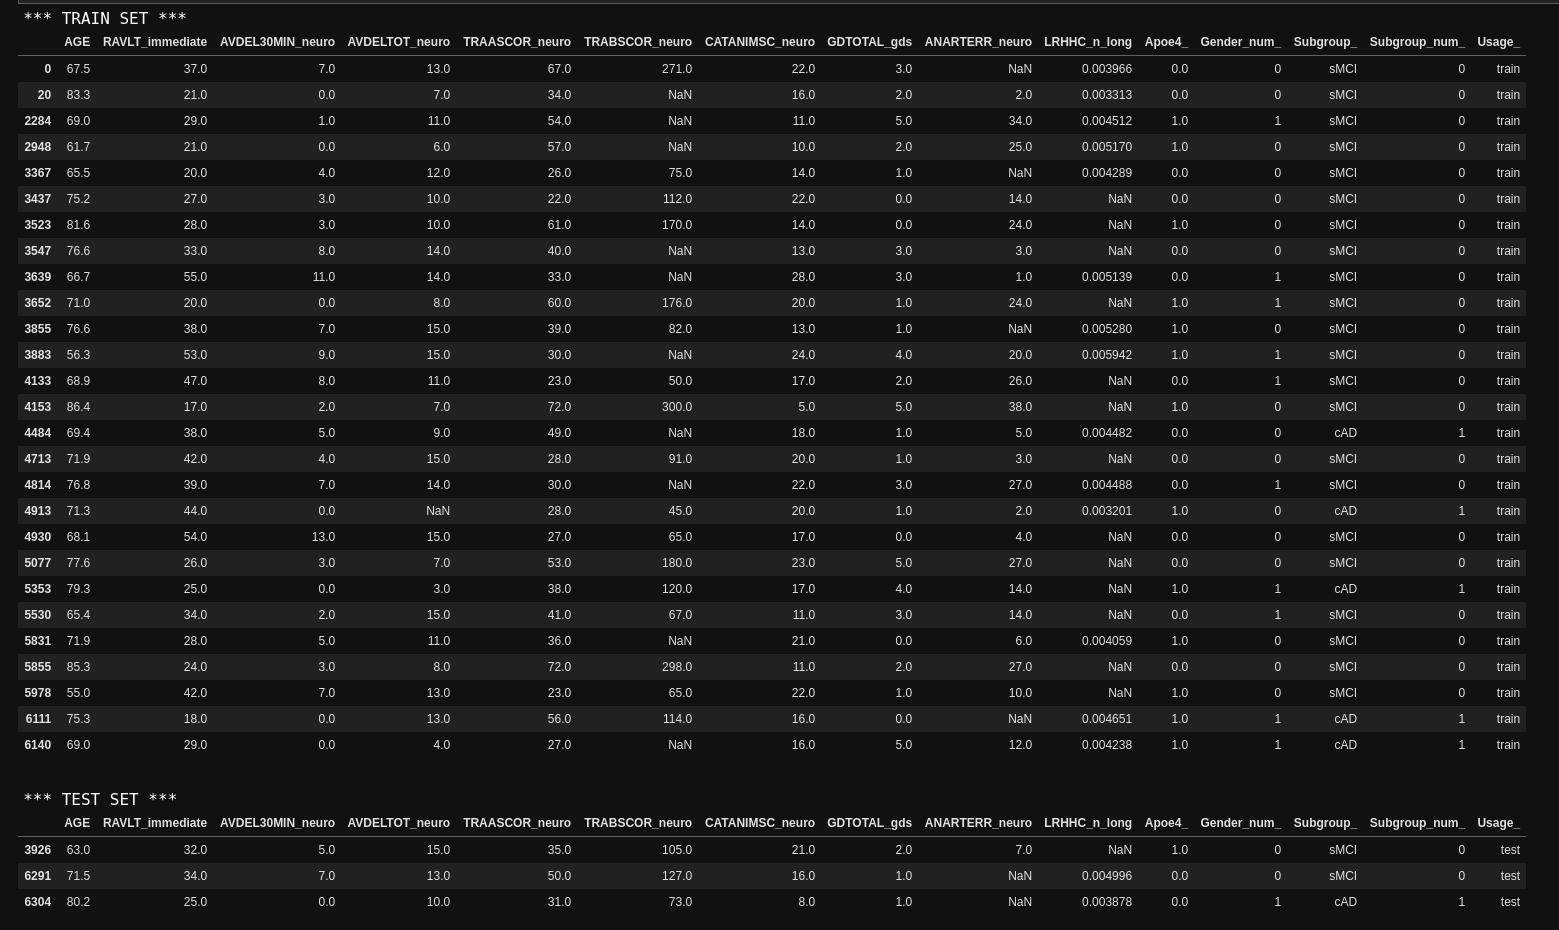

In [15]:
Image(filename="figs/assets/NaN_subjects.png")

### DROP NAN VALUES FROM TRAIN AND TEST SETS (IF ANY)

In [16]:
print('\nSubjects number in both sets AFTER dropping NaN values:\n')
for name, bl in bl_sets:
    bl.dropna(axis='rows', inplace=True)
    print(f' - {name}: {bl.shape[0]}')


Subjects number in both sets AFTER dropping NaN values:

 - Train set: 539
 - Test set: 139


In [17]:
if 1:
    for name, bl in bl_sets:        
        print(f'*** NaN values in {name.upper()} set (out of {bl.shape[0]} rows) ***')
        print(bl.isnull().sum().to_string())
        print(f'\nRows in {name}: {bl.shape[0]}')
        print('\n\n')

*** NaN values in TRAIN SET set (out of 539 rows) ***
AGE                 0
RAVLT_immediate     0
AVDEL30MIN_neuro    0
AVDELTOT_neuro      0
TRAASCOR_neuro      0
TRABSCOR_neuro      0
CATANIMSC_neuro     0
GDTOTAL_gds         0
ANARTERR_neuro      0
LRHHC_n_long        0
Apoe4_              0
Gender_num_         0
Subgroup_           0
Subgroup_num_       0
Usage_              0

Rows in Train set: 539



*** NaN values in TEST SET set (out of 139 rows) ***
AGE                 0
RAVLT_immediate     0
AVDEL30MIN_neuro    0
AVDELTOT_neuro      0
TRAASCOR_neuro      0
TRABSCOR_neuro      0
CATANIMSC_neuro     0
GDTOTAL_gds         0
ANARTERR_neuro      0
LRHHC_n_long        0
Apoe4_              0
Gender_num_         0
Subgroup_           0
Subgroup_num_       0
Usage_              0

Rows in Test set: 139





### COUNT TRAIN / TEST  PERCENTAGE PROPORTION AFTER EXCLUDING NaN VALUES

In [18]:
print('Subjects in:')
for name, bl in bl_sets:
    print(f'\t{name}:\t{bl.shape[0]} ({bl.shape[0]/(bl_train.shape[0] + bl_test.shape[0]) * 100:.0f}%)')

print('\n\nSubjects in each subgroup (with NaN included):\n')
for name, bl in bl_sets:
    print(f'*** {name} ***\n{bl.Subgroup_.value_counts().to_string()}\n')

Subjects in:
	Train set:	539 (79%)
	Test set:	139 (21%)


Subjects in each subgroup (with NaN included):

*** Train set ***
sMCI    283
cAD     256

*** Test set ***
sMCI    74
cAD     65



---

## RANDOM FORESTS CLASSIFICATION

### CREATE X AND y

In [19]:
# train set
X_train = bl_train.copy(deep=True)
y_train = X_train.Subgroup_num_

# test set
X_test = bl_test.copy(deep=True)
y_test = X_test.Subgroup_num_

# a list of both sets, to ease forfurther manipulation
X_sets = [['X train set', X_train], ['X test set', X_test]]
y_sets = [['y train set', y_train], ['y test set', y_test]]

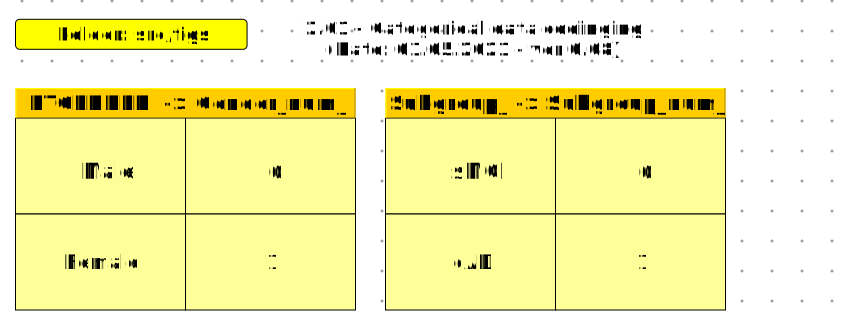

In [20]:
SVG(filename='figs/2.01_preprocessing_categorical_2_num.svg')

### REMOVE `SUBGROUP_`, `Subgroup_num_` and `Usage_` COLUMNS FROM THE TRAIN & TEST SETS

In [21]:
print('From:')
for name, X in X_sets:
    print(f'\t{name}')
    if 'Subgroup_' in X.columns: X.drop(columns='Subgroup_',inplace=True); print('\t\tRemoved: Subgroups_')
    if 'Subgroup_num_' in X.columns: X.drop(columns='Subgroup_num_',inplace=True); print('\t\tRemoved: Subgroups_num_')
    if 'Usage_' in X.columns: X.drop(columns='Usage_',inplace=True); print('\t\tRemoved: Usage_')

From:
	X train set
		Removed: Subgroups_
		Removed: Subgroups_num_
		Removed: Usage_
	X test set
		Removed: Subgroups_
		Removed: Subgroups_num_
		Removed: Usage_


In [22]:
print('Column names in:\n')
for name, X in X_sets:
    print(f'- {name}:\n  {X.columns.to_list()}\n')

Column names in:

- X train set:
  ['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds', 'ANARTERR_neuro', 'LRHHC_n_long', 'Apoe4_', 'Gender_num_']

- X test set:
  ['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds', 'ANARTERR_neuro', 'LRHHC_n_long', 'Apoe4_', 'Gender_num_']



In [23]:
if 1:
    print('Basic statistics for features in both sets:')
    for name, X in X_sets:
        print(f'\n{name} (Subjects {X.shape[0]}):')
        display(minfo.df_stats_info(X))

Basic statistics for features in both sets:

X train set (Subjects 539):


max.        mean      min.        std   val_range  \
AGE                91.400000   73.551948  55.20000   7.248462   36.200000   
RAVLT_immediate    67.000000   33.129870  11.00000  10.344881   56.000000   
AVDEL30MIN_neuro   15.000000    3.526902   0.00000   3.737771   15.000000   
AVDELTOT_neuro     15.000000   10.319109   0.00000   3.488460   15.000000   
TRAASCOR_neuro    150.000000   42.029685  13.00000  18.349940  137.000000   
TRABSCOR_neuro    300.000000  121.272727  33.00000  66.949280  267.000000   
CATANIMSC_neuro    35.000000   16.820037   5.00000   5.144663   30.000000   
GDTOTAL_gds         6.000000    1.692022   0.00000   1.448545    6.000000   
ANARTERR_neuro     50.000000   13.204082   0.00000   9.437483   50.000000   
LRHHC_n_long        0.006486    0.004277   0.00234   0.000768    0.004146   
Apoe4_              1.000000    0.525046   0.00000   0.499836    1.000000   
Gender_num_         1.000000    0.398887   0.00000   0.490124    1.000000   

                  NaN_Nr  
AGE                    0  
RAVLT_immediate        0  
AVDEL30MIN_neuro       0  
AVDELTOT_neuro         0  
TRAASCOR_neuro         0  
TRABSCOR_neuro         0  
CATANIMSC_neuro        0  
GDTOTAL_gds            0  
ANARTERR_neuro         0  
LRHHC_n_long           0  
Apoe4_                 0  
Gender_num_            0


X test set (Subjects 139):


max.        mean      min.        std  val_range  \
AGE                88.400000   73.335252  55.00000   7.514391   33.40000   
RAVLT_immediate    65.000000   34.014388  20.00000   8.734394   45.00000   
AVDEL30MIN_neuro   14.000000    3.582734   0.00000   3.411191   14.00000   
AVDELTOT_neuro     15.000000   10.647482   1.00000   3.428067   14.00000   
TRAASCOR_neuro    150.000000   40.978417  16.00000  20.452301  134.00000   
TRABSCOR_neuro    300.000000  116.338129  38.00000  65.936460  262.00000   
CATANIMSC_neuro    30.000000   17.100719   6.00000   4.772043   24.00000   
GDTOTAL_gds         5.000000    1.640288   0.00000   1.256907    5.00000   
ANARTERR_neuro     44.000000   12.532374   0.00000   9.616789   44.00000   
LRHHC_n_long        0.006521    0.004186   0.00277   0.000778    0.00375   
Apoe4_              1.000000    0.532374   0.00000   0.500755    1.00000   
Gender_num_         1.000000    0.410072   0.00000   0.493625    1.00000   

                  NaN_Nr  
AGE                    0  
RAVLT_immediate        0  
AVDEL30MIN_neuro       0  
AVDELTOT_neuro         0  
TRAASCOR_neuro         0  
TRABSCOR_neuro         0  
CATANIMSC_neuro        0  
GDTOTAL_gds            0  
ANARTERR_neuro         0  
LRHHC_n_long           0  
Apoe4_                 0  
Gender_num_            0

---

# GRID SEARCH (PERFORM  OR LOAD)

In [24]:
# Run gridsearch (if grid_search=1) and save the model to a file
# Load the best model from the file (if grid_search = 0)
grid_search = 0

# A filename of the the whole ridsearch structure
file_name_prefix_ext = file_name_prefix + '.pkl'
file_name_prefix_path = RESULTS_DIR / file_name_prefix_ext

# define a stratification sheme
skf = StratifiedKFold(n_splits=10)

if grid_search:       
    print("Searching the best RF's parameters...")
    pipe = make_pipeline(StandardScaler(),RandomForestClassifier(random_state=42))
    #sorted(pipe.get_params().keys())

    params = {"randomforestclassifier__n_estimators": [410, 420, 430],
              "randomforestclassifier__max_depth": [4, 5, 6],
              "randomforestclassifier__max_features": [2, 3, 4],
              "randomforestclassifier__min_samples_split": [1, 2, 3],
              "randomforestclassifier__min_samples_leaf": [1, 2, 3],
              "randomforestclassifier__bootstrap": [True, False],
              "randomforestclassifier__criterion": ["gini", "entropy"]}
    
    #params = {"randomforestclassifier__n_estimators": [373, 374, 375]}
    
    grid = GridSearchCV(estimator=pipe, param_grid=params, verbose=1, refit=True, cv=skf, n_jobs=-1)
    # fit the best estimator to the train data
    grid.fit(X_train, y_train)
    # save best estimator to the file
    joblib.dump(grid, file_name_prefix_path)     
    print(f'Saved GridSearch object to: {file_name_prefix_path}')
else:
    print(f"GridSearch parameters loaded from a file:\n\t\t{file_name_prefix_path}")
    grid = joblib.load(file_name_prefix_path)     

    
clf = grid.best_estimator_

print()
print(f'Best score: {grid.best_score_:.3f}\n')
print(f'Best params:')
for k,v in grid.best_params_.items():
    print(f'\t{k}: {v}')
#print(grid.cv_results_)

GridSearch parameters loaded from a file:
		/home/marek/Dropbox/p1ext4_P/no_work/MCI/MCI-subgroups/results/20210420/3.09_template.pkl

Best score: 0.738

Best params:
	randomforestclassifier__bootstrap: True
	randomforestclassifier__criterion: entropy
	randomforestclassifier__max_depth: 5
	randomforestclassifier__max_features: 3
	randomforestclassifier__min_samples_leaf: 2
	randomforestclassifier__min_samples_split: 2
	randomforestclassifier__n_estimators: 420


---

# A PIPELINE WITH ESTABLISHED RF PARAMETERS (AFTER GRID SEARCH) 

### FEATURE STANDARIZATION IN THE TRAIN SET

In [25]:
# Standarization - standar scaler from scikit-learn
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled.set_index(X_train.index, inplace=True)

X_sets_scaled = [['X train set scaled', X_train_scaled], ['X test set scaled', X_test_scaled]]

#### TABLE CONTENT CHECKING (OPTIONAL)

In [26]:
if 1:    
    tmp_df = pd.DataFrame.from_dict({'X_train_mean':X_train.mean().round(2), 'X_train_std':X_train.std().round(2), 
                        'X_train_scaled_mean':X_train_scaled.mean().round(2), 'X_train_scaled_std':X_train_scaled.std().round(2)})
    
    display(X_train.head())
    display(X_train_scaled.head())
    display(tmp_df)

AGE  RAVLT_immediate  AVDEL30MIN_neuro  AVDELTOT_neuro  TRAASCOR_neuro  \
13  80.0             36.0               1.0             8.0            47.0   
26  76.8             27.0               5.0            10.0            61.0   
29  70.9             22.0               0.0             0.0            18.0   
37  72.8             29.0               1.0             8.0            40.0   
55  77.6             30.0               2.0            14.0           150.0   

    TRABSCOR_neuro  CATANIMSC_neuro  GDTOTAL_gds  ANARTERR_neuro  \
13           139.0             16.0          1.0             4.0   
26           300.0             19.0          4.0            23.0   
29           145.0             18.0          2.0            12.0   
37           101.0             17.0          1.0             6.0   
55           300.0             12.0          0.0             9.0   

    LRHHC_n_long  Apoe4_  Gender_num_  
13      0.003458     0.0            1  
26      0.005251     0.0            0  
29      0.003026     1.0            1  
37      0.002767     0.0            0  
55      0.002814     0.0            0

AGE  RAVLT_immediate  AVDEL30MIN_neuro  AVDELTOT_neuro  \
13  0.890402         0.277702         -0.676673       -0.665412   
26  0.448519        -0.593102          0.394478       -0.091561   
29 -0.366203        -1.076881         -0.944461       -2.960818   
37 -0.103835        -0.399590         -0.676673       -0.665412   
55  0.558989        -0.302834         -0.408885        1.056142   

    TRAASCOR_neuro  TRABSCOR_neuro  CATANIMSC_neuro  GDTOTAL_gds  \
13        0.271114        0.265033        -0.159544    -0.478180   
26        1.034768        2.672072         0.424127     1.594788   
29       -1.310740        0.354736         0.229570     0.212809   
37       -0.110713       -0.303089         0.035013    -0.478180   
55        5.889426        2.672072        -0.937771    -1.169169   

    ANARTERR_neuro  LRHHC_n_long    Apoe4_  Gender_num_  
13       -0.976175     -1.068061 -1.051413     1.227590  
26        1.038944      1.269690 -1.051413    -0.814604  
29       -0.127704     -1.630936  0.951101     1.227590  
37       -0.764057     -1.968167 -1.051413    -0.814604  
55       -0.445880     -1.907182 -1.051413    -0.814604

X_train_mean  X_train_std  X_train_scaled_mean  \
AGE                      73.55         7.25                  0.0   
RAVLT_immediate          33.13        10.34                  0.0   
AVDEL30MIN_neuro          3.53         3.74                  0.0   
AVDELTOT_neuro           10.32         3.49                  0.0   
TRAASCOR_neuro           42.03        18.35                 -0.0   
TRABSCOR_neuro          121.27        66.95                  0.0   
CATANIMSC_neuro          16.82         5.14                 -0.0   
GDTOTAL_gds               1.69         1.45                  0.0   
ANARTERR_neuro           13.20         9.44                  0.0   
LRHHC_n_long              0.00         0.00                  0.0   
Apoe4_                    0.53         0.50                 -0.0   
Gender_num_               0.40         0.49                 -0.0   

                  X_train_scaled_std  
AGE                              1.0  
RAVLT_immediate                  1.0  
AVDEL30MIN_neuro                 1.0  
AVDELTOT_neuro                   1.0  
TRAASCOR_neuro                   1.0  
TRABSCOR_neuro                   1.0  
CATANIMSC_neuro                  1.0  
GDTOTAL_gds                      1.0  
ANARTERR_neuro                   1.0  
LRHHC_n_long                     1.0  
Apoe4_                           1.0  
Gender_num_                      1.0

### CATEGORICAL GENDER MAPPING NUMERICAL VALUES

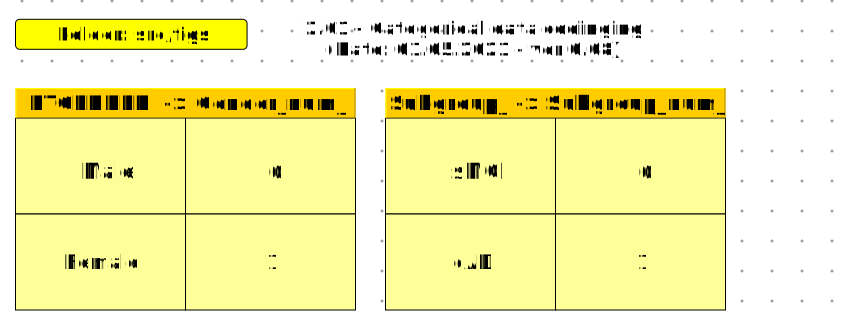

In [27]:
SVG(filename='figs/2.01_preprocessing_categorical_2_num.svg')

In [28]:
print('Subjects label sets (after removaing NaN values):')
for name, y in y_sets:
    print(f'\t{name}:\t{y.shape[0]} ({y.shape[0]/(y_train.shape[0] + y_test.shape[0]) * 100:.0f}%)')

print('\n\nSubjects in each subgroup (with NaN EXCLUDED):\n')
for name, y in y_sets:
    print(f'*** {name} ***\n{y.value_counts().to_string()}\n')

Subjects label sets (after removaing NaN values):
	y train set:	539 (79%)
	y test set:	139 (21%)


Subjects in each subgroup (with NaN EXCLUDED):

*** y train set ***
0    283
1    256

*** y test set ***
0    74
1    65



---

# RF MODEL WITH CV (10 FOLDS)

In [29]:
folds = 10


skf = StratifiedKFold(n_splits=folds, shuffle=False)
clf = RandomForestClassifier(random_state=0,
                             n_estimators=420,
                             max_depth=5,
                             bootstrap=True,
                             criterion='entropy',
                             min_samples_split=2,
                             min_samples_leaf=2,
                             max_features=3
                            )

# auxiliary structures (dfs, matrices) 
score_all = pd.DataFrame(index=[ 'f1_', 'acc_', 'recall_', 'prec_'], columns=list(range(folds)))
feat_importance_all = pd.DataFrame(index=X_train_scaled.columns, columns=list(range(folds)))
conf_matrix_all = np.zeros((folds, 2 ,2))
df_err_predictions_all = pd.DataFrame()
# to calculate mean validation test lenght, as it is 55 or 56
validCV_test_length_all = np.ones(10)



for k, (train_index, validation_index) in enumerate(skf.split(X_train_scaled, y_train)):
    #print("TRAIN:", train_index.shape, "VAL:", test_index.shape)
    X_trainCV, X_validCV = X_train_scaled.iloc[train_index,:], X_train_scaled.iloc[validation_index,:]
    y_trainCV, y_validCV = y_train.iloc[train_index], y_train.iloc[validation_index]
         
    # model fit
    clf.fit(X_trainCV, y_trainCV)

    # predict
    y_predCV= clf.predict(X_validCV).reshape(-1,)
    
    # metrics
    f1 = metrics.f1_score(y_validCV, y_predCV)
    acc = metrics.accuracy_score(y_validCV, y_predCV)
    recall = metrics.recall_score(y_validCV, y_predCV)
    prec = metrics.precision_score(y_validCV, y_predCV)
    # scores for all folds
    score_all[k] = [f1, acc, recall, prec]
    # confusion matrix for all folds
    conf_matrix_all[k, :, :]  = metrics.confusion_matrix(y_validCV, y_predCV)    
    # feature importance for all folds
    feat_importance_all[k] = clf.feature_importances_
    
    
    # add predictions and misclassifications to the training set
    X_validCV_extended = X_validCV.copy()
    X_validCV_extended['y_true_'] = np.where(y_validCV == 1, 'cAD', 'sMCI')
    X_validCV_extended['y_pred_'] = np.where(y_predCV == 1, 'cAD', 'sMCI')
    X_validCV_extended[f'Fold_in_CV{folds}_'] = k
    X_validCV_extended['Usage2_'] = 'valid'    
    
    #df['value'] = [x if x > 0 else 'ww' for x in df['a']]
    #X_validation_extended['ErrorType_'] = np.where(y_validation == 1, 'FN', 'FP')
    
    # set current validation test set length
    validCV_test_length_all[k] = len(y_validCV)
    
    # df with misclasified subjects in the current fold (k)
    err = X_validCV_extended.loc[(X_validCV_extended.y_true_ != X_validCV_extended.y_pred_)]
    print(f'fold: {k}, errors: {err.shape[0]}/{y_validCV.shape[0]}  ({err.shape[0]/y_validCV.shape[0]*100 :.1f}%)')
    
    # df to agregate misclassifications from all folds
    df_err_predictions_all = pd.concat([df_err_predictions_all, err], axis=0)    

fold: 0, errors: 19/54  (35.2%)
fold: 1, errors: 16/54  (29.6%)
fold: 2, errors: 14/54  (25.9%)
fold: 3, errors: 15/54  (27.8%)
fold: 4, errors: 8/54  (14.8%)
fold: 5, errors: 10/54  (18.5%)
fold: 6, errors: 21/54  (38.9%)
fold: 7, errors: 13/54  (24.1%)
fold: 8, errors: 12/54  (22.2%)
fold: 9, errors: 19/53  (35.8%)


---

# MODEL ANALYSIS

## MISCLASSIFIED SUBJECT TABLE

#### IDENTIFY MISCLCASSIFIED PATIENTS IN THE ORIGIN `BL` TABLE (WITH ALL COLUMNS) AND LINK BOTH TABLES

In [30]:
#idx = df_err_predictions.loc[df_err_predictions.fold_nr_ == 0].index

# get misclassified subject rows from bl_loaded table (wiht all columns presented in bl.csv) 
bl_miss = bl_loaded.loc[df_err_predictions_all.index]

# select some columns from misclassified subject df
cols = ['y_true_', 'y_pred_', f'Fold_in_CV{folds}_',  'Usage2_']
df_err_predictions_all = df_err_predictions_all[cols]

# merge both tables by index
bl_miss = bl_miss.merge(df_err_predictions_all, how='left', left_index=True, right_index=True, indicator='MERGE_misclassification_k10_')

print(f'\nMisclassified subjests: {bl_miss.shape[0]}\n')


Misclassified subjests: 147



In [31]:
df_err_predictions_all.head(3)

y_true_ y_pred_  Fold_in_CV10_ Usage2_
89     sMCI     cAD              0   valid
100     cAD    sMCI              0   valid
108    sMCI     cAD              0   valid

#### ITERATE OVER MISCLASSIFIED SUBJECTS IN EACH FOLD

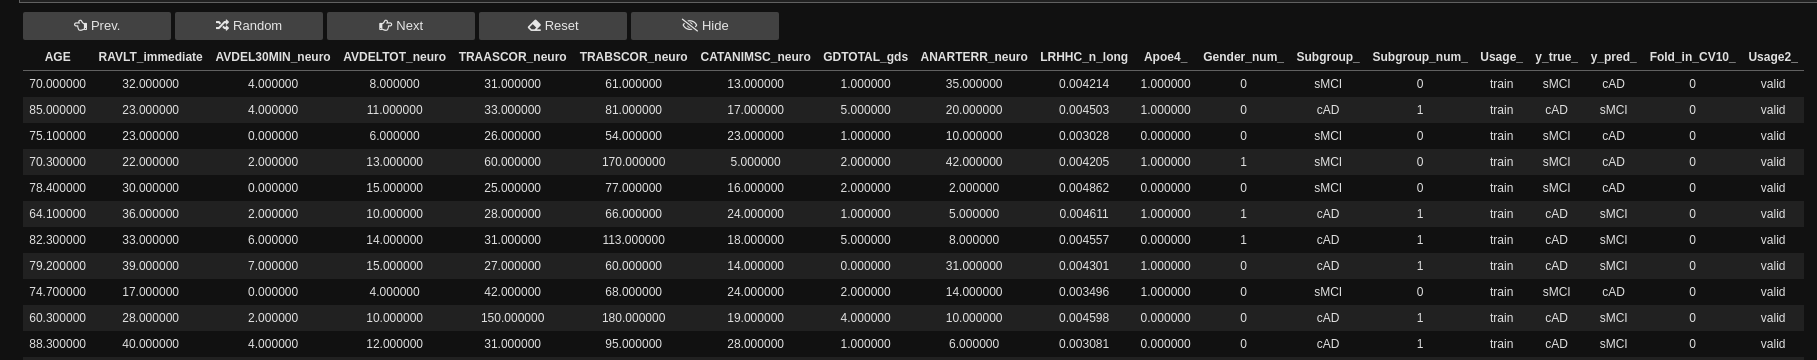

In [32]:
Image(filename="figs/assets/misclassified_subjects.png")

In [33]:
if 1:
    cols = features + df_err_predictions_all.columns.to_list()
    minfo.iterate_patient_GUI(bl_miss[cols], column=f'Fold_in_CV{folds}_')

#### SAVE MISCLASSIFIED SUBJESTS TO THE FILE (OPTIONAL)

In [34]:
save = 1

if save:     
    # filename
    filename = file_name_prefix + '_bl_missclassified.csv'
    # path to save
    bl_misclassified_name = RESULTS_DIR / filename
    # sort by RID
    bl_miss.sort_values(by=['RID'], inplace=True) 
    # save to file
    bl_miss.to_csv(bl_misclassified_name, index=True)
    # printed info
    print(f'Missclassified subjects were identified in THE MAIN BL TABLD and saved to the file:\n')
    print(f'\t\t{bl_misclassified_name}')

Missclassified subjects were identified in THE MAIN BL TABLD and saved to the file:

		/home/marek/Dropbox/p1ext4_P/no_work/MCI/MCI-subgroups/results/20210420/3.09_template_bl_missclassified.csv


---

## FEATURE IMPORTANCE (AVERAGE OUT OF 10 FOLDS)

In [35]:
feat_importance_all.reset_index(inplace=True)
feat_importance_all = feat_importance_all.rename({'index': 'feature'}, axis='columns')

#### FATURE IMPORTANCE IN EACH FOLD

In [36]:
if 1:
    display(feat_importance_all)

feature         0         1         2         3         4  \
0                AGE  0.066415  0.064430  0.060076  0.065551  0.073332   
1    RAVLT_immediate  0.205061  0.195024  0.195040  0.181898  0.184961   
2   AVDEL30MIN_neuro  0.156769  0.161603  0.156593  0.149804  0.146166   
3     AVDELTOT_neuro  0.061226  0.053505  0.059542  0.051748  0.051035   
4     TRAASCOR_neuro  0.064116  0.072421  0.061204  0.060795  0.066063   
5     TRABSCOR_neuro  0.085636  0.081598  0.089047  0.078751  0.079885   
6    CATANIMSC_neuro  0.049301  0.055226  0.063113  0.056438  0.059537   
7        GDTOTAL_gds  0.024626  0.020892  0.024028  0.023957  0.026485   
8     ANARTERR_neuro  0.055579  0.056719  0.058708  0.068960  0.055040   
9       LRHHC_n_long  0.188077  0.192634  0.196523  0.210858  0.205588   
10            Apoe4_  0.029166  0.033214  0.021815  0.035076  0.036800   
11       Gender_num_  0.014029  0.012734  0.014311  0.016162  0.015108   

           5         6         7         8         9  
0   0.074456  0.063914  0.066629  0.070369  0.065967  
1   0.199019  0.207478  0.181678  0.186540  0.174350  
2   0.149764  0.183302  0.157621  0.158872  0.167602  
3   0.057416  0.058301  0.049980  0.056278  0.055235  
4   0.064752  0.052948  0.063245  0.060592  0.061000  
5   0.077237  0.076494  0.090349  0.070218  0.085297  
6   0.060914  0.053730  0.053961  0.051204  0.052877  
7   0.025742  0.022971  0.024315  0.025016  0.024908  
8   0.067174  0.055750  0.059043  0.059660  0.057041  
9   0.170777  0.188203  0.210847  0.216497  0.210957  
10  0.037081  0.022302  0.027577  0.031285  0.034113  
11  0.015666  0.014607  0.014755  0.013469  0.010654

#### AVERAGE FEATURE IMPORTANCE OVER 10 FOLDS

In [37]:
feat_importance_all_stats = pd.DataFrame.from_dict({'feature':feat_importance_all.feature, 'mean':feat_importance_all.mean(axis=1).round(2), 'std.':feat_importance_all.std(axis=1).round(2)})
feat_importance_all_stats.sort_values(by='mean',ascending=False)

feature  mean  std.
9       LRHHC_n_long  0.20  0.01
1    RAVLT_immediate  0.19  0.01
2   AVDEL30MIN_neuro  0.16  0.01
5     TRABSCOR_neuro  0.08  0.01
0                AGE  0.07  0.00
3     AVDELTOT_neuro  0.06  0.00
4     TRAASCOR_neuro  0.06  0.00
6    CATANIMSC_neuro  0.06  0.00
8     ANARTERR_neuro  0.06  0.00
10            Apoe4_  0.03  0.01
7        GDTOTAL_gds  0.02  0.00
11       Gender_num_  0.01  0.00

In [38]:
def plot_mean_feature_importnce_cv(df, file_name_prefix=file_name_prefix, figsize=(20,10), folds=10, orientation='h', save=True):
    """
    C: 2021.05.03 / U: 2021.05.03
    """
    # transfer 2D df to 1D df (melt)
    #https://stackoverflow.com/questions/40877135/plotting-two-columns-of-dataframe-in-seaborn
    # label text size
    #https://stackoverflow.com/questions/12444716/how-do-i-set-the-figure-title-and-axes-labels-font-size-in-matplotlib

    fig, ax = plt.subplots(figsize=figsize)
    fig.suptitle('Mean feature importance for k=10 folds', fontsize=26,fontweight='bold')
    ax.set_xlabel('xlabel', fontsize=24)
    ax.set_ylabel('ylabel', fontsize=24) 
    ax.tick_params(labelsize=14)

    tidy = df.melt(id_vars='feature').rename(columns=str.title)
    tidy = tidy.sort_values(by=['Value'], ascending=False)
    if orientation == 'h':
        sns.barplot(x='Value', y='Feature', ci='sd', capsize=.2, data=tidy, ax=ax, orient=orientation)
    else:
        sns.barplot(x='Feature', y='Value', ci='sd', capsize=.2, data=tidy, ax=ax, orient=orientation)
    sns.despine(fig)

    if save:
        file_name_prefix_ext = f'{file_name_prefix}-CV{folds}-feat-importance-{orientation}.png'
        file_name_prefix_path = RESULTS_DIR / file_name_prefix_ext
        plt.savefig(file_name_prefix_path)
        print(f'Mean featue importacne plot saved to:\n\t\t{file_name_prefix_path}\n')
        

    plt.grid()
    plt.show()

#### PLOT MEAN FEATURE IMPORTANCE FOR 10 FOLDS (OPTIONAL: SAVE, SIZE, ORIENTATION, ...)

Mean featue importacne plot saved to:
		/home/marek/Dropbox/p1ext4_P/no_work/MCI/MCI-subgroups/results/20210420/3.09_template-CV10-feat-importance-h.png



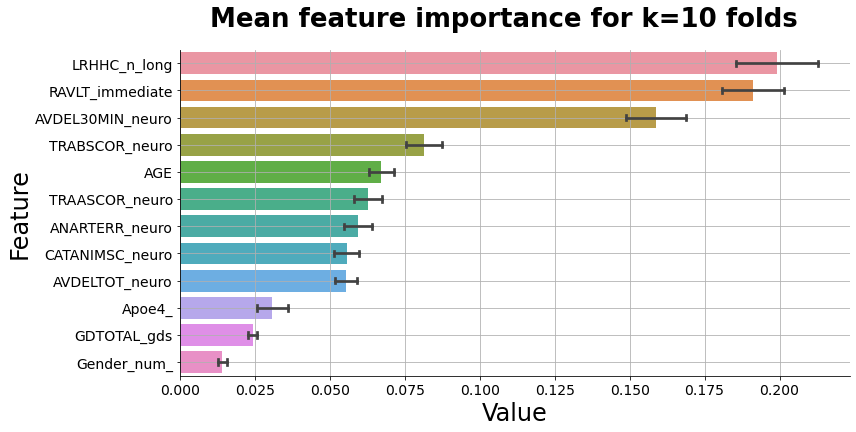

Mean featue importacne plot saved to:
		/home/marek/Dropbox/p1ext4_P/no_work/MCI/MCI-subgroups/results/20210420/3.09_template-CV10-feat-importance-v.png



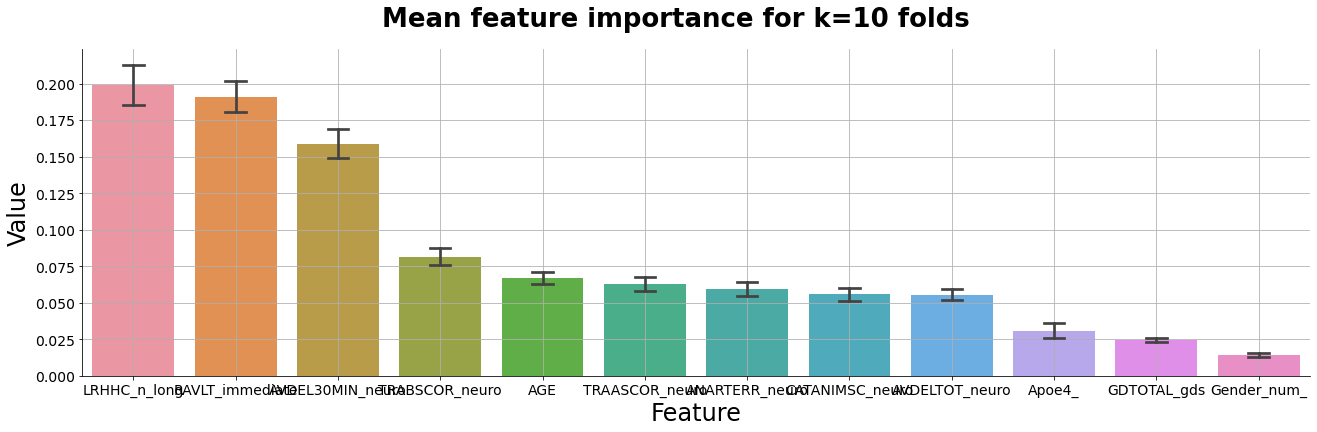

In [39]:
plot_mean_feature_importnce_cv(feat_importance_all, orientation='h', figsize=(12,6))
plot_mean_feature_importnce_cv(feat_importance_all, orientation='v', figsize=(22,6))

---

## CV10 SCORES (F1, ACCURACY, REACALL, PRECISION)

In [40]:
display(score_all)
score_all_mean = pd.DataFrame.from_dict({'mean':score_all.mean(axis=1).round(3), 'std.':score_all.std(axis=1).round(4)})
print(f'\n\nMean score values for crossvalidation (k={folds} folds):\n')
display(score_all_mean)

0         1         2         3         4         5         6  \
f1_      0.666667  0.733333  0.766667  0.754098  0.840000  0.814815  0.511628   
acc_     0.648148  0.703704  0.740741  0.722222  0.851852  0.814815  0.611111   
recall_  0.730769  0.846154  0.884615  0.884615  0.807692  0.846154  0.440000   
prec_    0.612903  0.647059  0.676471  0.657143  0.875000  0.785714  0.611111   

                7         8         9  
f1_      0.734694  0.750000  0.654545  
acc_     0.759259  0.777778  0.641509  
recall_  0.720000  0.720000  0.720000  
prec_    0.750000  0.782609  0.600000



Mean score values for crossvalidation (k=10 folds):



mean    std.
f1_      0.723  0.0934
acc_     0.727  0.0779
recall_  0.760  0.1318
prec_    0.700  0.0931

---

## CONFUSION MATRIX

#### NUMBER OF SUBJECTS IN EACH FOLD

In [41]:
print(f'Subjects in each fold:\n\t{validCV_test_length_all}\n')
print(f'Meand fold length: {validCV_test_length_all.mean()}')

Subjects in each fold:
	[54. 54. 54. 54. 54. 54. 54. 54. 54. 53.]

Meand fold length: 53.9


#### PLOT CONFUSION MATRIX

Confusion matrix saved to:

		/home/marek/Dropbox/p1ext4_P/no_work/MCI/MCI-subgroups/results/20210420/3.09_template-conf-matrix-CV10.png



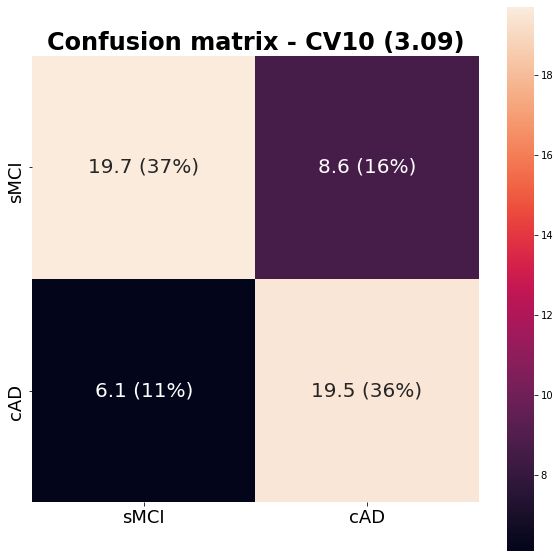

In [42]:
# mean of confusion matix over k=10 folds
conf_mat_mean = conf_matrix_all.mean(axis=0)
# percantage values of confusion matix according to validatin set lenght
conf_mat_mean_prc = conf_mat_mean / validCV_test_length_all.mean() * 100


title = f'Confusion matrix - CV{folds} ({file_name_number})'
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect(aspect=1)
lab = ['sMCI', 'cAD']
res = sns.heatmap(conf_mat_mean, annot=True, xticklabels=lab, yticklabels=lab, ax=ax,annot_kws={"fontsize":20}, fmt='.1f')
ax.tick_params(axis='both', which='major', labelsize=18)
_ = ax.set_title(title, size=24, fontweight='bold')


for t,p in zip(res.texts, conf_mat_mean_prc.flat):
    p = np.asarray(np.round(p,0), int)
    t.set_text(t.get_text() + f' ({p}%)')
    
file_name_prefix_ext = f'{file_name_prefix}-conf-matrix-CV{folds}.png'
file_name_prefix_path = RESULTS_DIR / file_name_prefix_ext
print(f'Confusion matrix saved to:\n\n\t\t{file_name_prefix_path}\n')
plt.savefig(file_name_prefix_path)

---

## CORELATION (OPTIONAL)

In [43]:
if 0:
    cor = X_train_scaled.corr()
    plt.figure(figsize=(18,16))
    sns.heatmap(cor, annot=True, cmap='RdBu_r')

---

## VISUALIZATION (OPTIONAL)

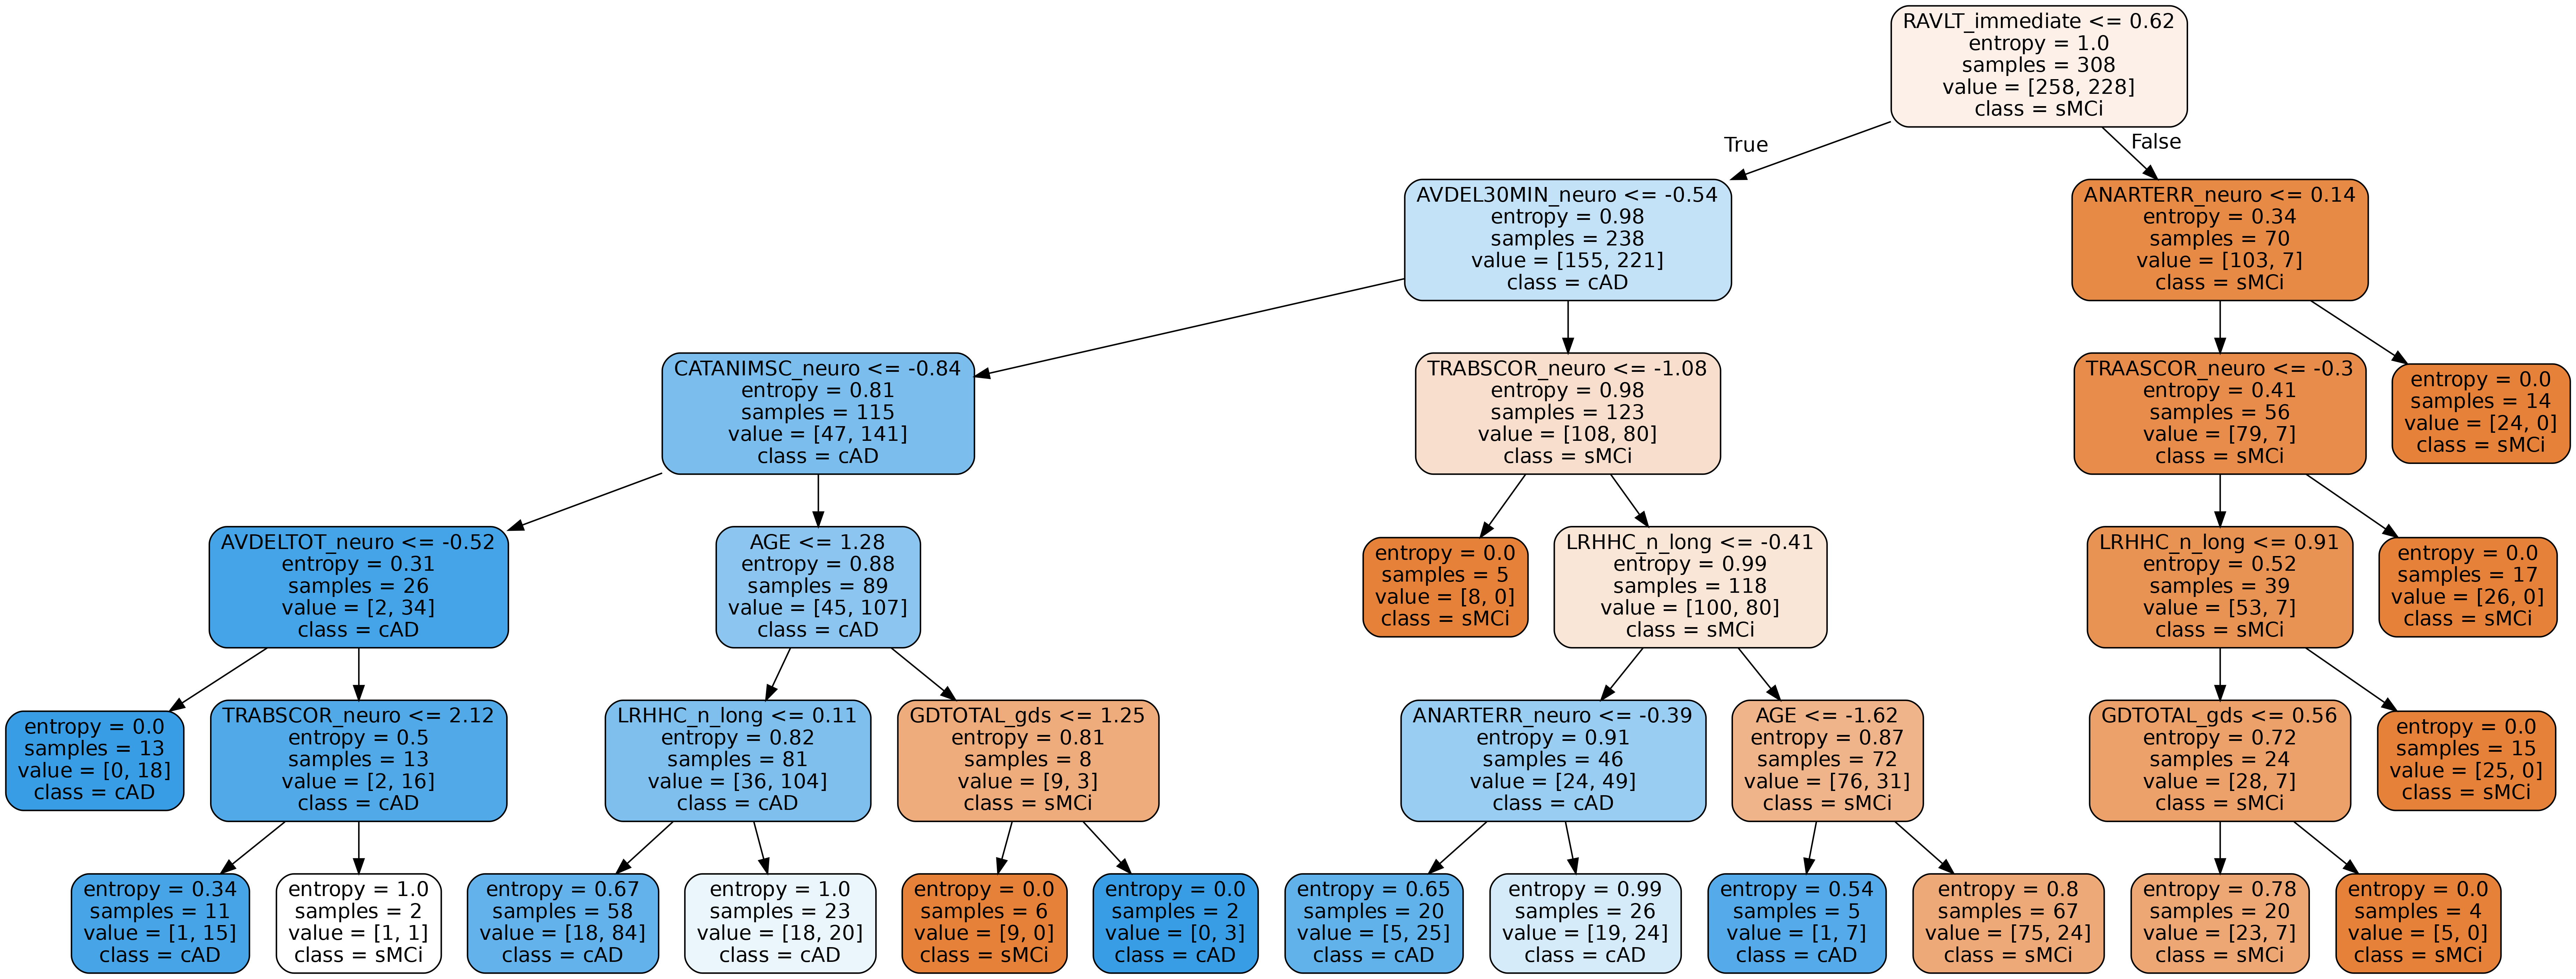

In [44]:
if 1:
    #https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c
    # Extract single tree
    estimator = clf.estimators_[4]

    from sklearn.tree import export_graphviz
    # Export as dot file
    export_graphviz(estimator, out_file='tree.dot', 
                    feature_names = X_train_scaled.columns,
                    class_names = ['sMCi','cAD'],
                    rounded = True, proportion = False, 
                    precision = 2, filled = True)

    # Convert to png using system command (requires Graphviz)
    from subprocess import call
    filename1 = file_name_prefix + '.png'
    filename2 = file_name_prefix + '.pdf'

    filepath1 = RESULTS_DIR/filename1
    filepath2 = RESULTS_DIR/filename2

    call(['dot', '-Tpng', 'tree.dot', '-o', filepath1, '-Gdpi=300'])
    call(['dot', '-Tpdf', 'tree.dot', '-o', filepath2, '-Gdpi=600'])

    # Display in jupyter notebook
    display(Image(filename=filepath1))

#### REMOVE TEMPORARY `tree.png` and `tree.dot` FILES FROM THE CURRENT FOLDER

In [45]:
if 1:
    [f.unlink() for f in list(Path('.').glob("tree.*"))]

---

# TEST SET

#### TEST SET SCALED (NUMPY) AS DATA FRAME

In [46]:
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
print(X_test_scaled_df.shape)
display(X_test_scaled_df.head(3))

(139, 12)


AGE  RAVLT_immediate  AVDEL30MIN_neuro  AVDELTOT_neuro  \
0  0.945637        -0.302834         -0.676673       -0.952338   
1  0.517563        -0.399590         -0.944461        0.195365   
2  0.545180         0.180946         -0.676673       -0.091561   

   TRAASCOR_neuro  TRABSCOR_neuro  CATANIMSC_neuro  GDTOTAL_gds  \
0        0.380208        0.698599        -0.743214    -1.169169   
1        4.362118        0.444439         0.035013     0.212809   
2       -0.819820       -0.781506         1.396910     0.212809   

   ANARTERR_neuro  LRHHC_n_long    Apoe4_  Gender_num_  
0        0.402591     -0.833352 -1.051413     1.227590  
1       -1.082234     -1.217417  0.951101    -0.814604  
2        0.932885     -1.470373  0.951101     1.227590

### TEST SETS VISUAL INSPECTIONS (OPTIONAL)

In [47]:
if 1:    
    tmp_df = pd.DataFrame.from_dict({'X_test_mean':X_test.mean().round(2), 'X_test_std':X_test.std().round(2), 
                        'X_test_scaled_mean':X_test_scaled_df.mean().round(2), 'X_test_scaled_std':X_test_scaled_df.std().round(2)})
    
    print('"Original" Test set ')
    display(X_test.head())
    print('\nTest  set scaled (StandardScaler())')
    display(X_test_scaled_df.head())
    print('\nMean and std comparison')
    display(tmp_df)

"Original" Test set 


AGE  RAVLT_immediate  AVDEL30MIN_neuro  AVDELTOT_neuro  TRAASCOR_neuro  \
6    80.4             30.0               1.0             7.0            49.0   
82   77.3             29.0               0.0            11.0           122.0   
184  77.5             35.0               1.0            10.0            27.0   
359  71.1             24.0               0.0             2.0            50.0   
384  83.6             30.0               2.0             9.0            22.0   

     TRABSCOR_neuro  CATANIMSC_neuro  GDTOTAL_gds  ANARTERR_neuro  \
6             168.0             13.0          0.0            17.0   
82            151.0             17.0          2.0             3.0   
184            69.0             24.0          2.0            22.0   
359            85.0             13.0          2.0             7.0   
384            76.0             18.0          0.0             9.0   

     LRHHC_n_long  Apoe4_  Gender_num_  
6        0.003638     0.0            1  
82       0.003343     1.0            0  
184      0.003149     1.0            1  
359      0.003729     0.0            1  
384      0.003700     0.0            1


Test  set scaled (StandardScaler())


AGE  RAVLT_immediate  AVDEL30MIN_neuro  AVDELTOT_neuro  \
0  0.945637        -0.302834         -0.676673       -0.952338   
1  0.517563        -0.399590         -0.944461        0.195365   
2  0.545180         0.180946         -0.676673       -0.091561   
3 -0.338586        -0.883369         -0.944461       -2.386966   
4  1.387520        -0.302834         -0.408885       -0.378486   

   TRAASCOR_neuro  TRABSCOR_neuro  CATANIMSC_neuro  GDTOTAL_gds  \
0        0.380208        0.698599        -0.743214    -1.169169   
1        4.362118        0.444439         0.035013     0.212809   
2       -0.819820       -0.781506         1.396910     0.212809   
3        0.434755       -0.542297        -0.743214     0.212809   
4       -1.092553       -0.676852         0.229570    -1.169169   

   ANARTERR_neuro  LRHHC_n_long    Apoe4_  Gender_num_  
0        0.402591     -0.833352 -1.051413     1.227590  
1       -1.082234     -1.217417  0.951101    -0.814604  
2        0.932885     -1.470373  0.951101     1.227590  
3       -0.657998     -0.713829 -1.051413     1.227590  
4       -0.445880     -0.751487 -1.051413     1.227590


Mean and std comparison


X_test_mean  X_test_std  X_test_scaled_mean  \
AGE                     73.34        7.51               -0.03   
RAVLT_immediate         34.01        8.73                0.09   
AVDEL30MIN_neuro         3.58        3.41                0.01   
AVDELTOT_neuro          10.65        3.43                0.09   
TRAASCOR_neuro          40.98       20.45               -0.06   
TRABSCOR_neuro         116.34       65.94               -0.07   
CATANIMSC_neuro         17.10        4.77                0.05   
GDTOTAL_gds              1.64        1.26               -0.04   
ANARTERR_neuro          12.53        9.62               -0.07   
LRHHC_n_long             0.00        0.00               -0.12   
Apoe4_                   0.53        0.50                0.01   
Gender_num_              0.41        0.49                0.02   

                  X_test_scaled_std  
AGE                            1.04  
RAVLT_immediate                0.85  
AVDEL30MIN_neuro               0.91  
AVDELTOT_neuro                 0.98  
TRAASCOR_neuro                 1.12  
TRABSCOR_neuro                 0.99  
CATANIMSC_neuro                0.93  
GDTOTAL_gds                    0.87  
ANARTERR_neuro                 1.02  
LRHHC_n_long                   1.01  
Apoe4_                         1.00  
Gender_num_                    1.01

## PREDICT SUBGROPUS WITH THE USE OF UNSEEN TEST SET

In [48]:
y_test_pred = clf.predict(X_test_scaled)
#compare two ways of accuracy calucation
if 0:
    print(metrics.accuracy_score(y_test, y_test_pred))
    print(clf.score(X_test_scaled, y_test))

## TEST SET SCORES (F1, ACCURACY, RECALL, PRECISION)

In [49]:
# metrics
f1 = metrics.f1_score(y_test, y_test_pred)
acc = metrics.accuracy_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test, y_test_pred)
prec = metrics.precision_score(y_test, y_test_pred)

print(f'F1: {f1:.3f}')
print(f'ACC: {acc:.3f}')
print(f'RECALL: {recall:.3f}')
print(f'PREC: {prec:.3f}')

F1: 0.620
ACC: 0.647
RECALL: 0.615
PREC: 0.625


## CONUSIOM MATRIX

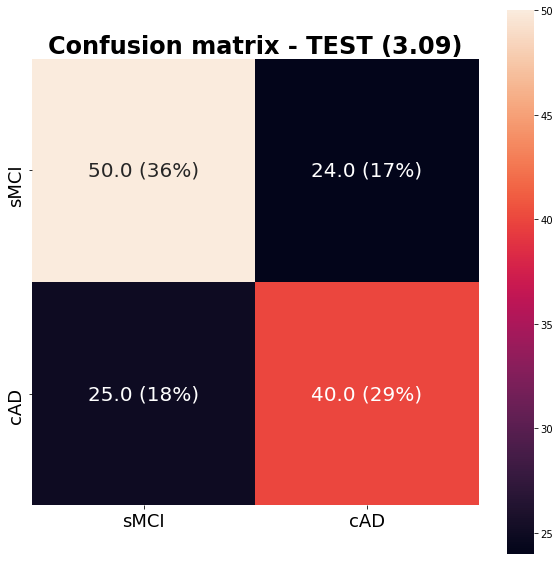

In [50]:
conf_matrix_test  = metrics.confusion_matrix(y_test, y_test_pred)    

# mean of confusion matix over k=10 folds
conf_mat_mean = conf_matrix_all.mean(axis=0)
# percantage values of confusion matix according to validatin set lenght
conf_matrix_test_prc = conf_matrix_test / y_test.shape[0] * 100


title = f'Confusion matrix - TEST ({file_name_number})'
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect(aspect=1)
lab = ['sMCI', 'cAD']
res = sns.heatmap(conf_matrix_test, annot=True, xticklabels=lab, yticklabels=lab, ax=ax,annot_kws={"fontsize":20}, fmt='.1f')
ax.tick_params(axis='both', which='major', labelsize=18)
_ = ax.set_title(title, size=24, fontweight='bold')


for t,p in zip(res.texts, conf_matrix_test_prc.flat):
    p = np.asarray(np.round(p,0), int)
    t.set_text(t.get_text() + f' ({p}%)')
    
file_name_prefix_ext = f'{file_name_prefix}-conf-matrix-TEST.png'
file_name_prefix_path = RESULTS_DIR / file_name_prefix_ext
plt.savefig(file_name_prefix_path)

## FEATURE IMPORTANCE

In [51]:
feature_imp = pd.Series(clf.feature_importances_,index=X_train_scaled.columns).sort_values(ascending=False)
print(f'Feature importance for the train set:\n\n{feature_imp.to_string()}')

Feature importance for the train set:

LRHHC_n_long        0.210957
RAVLT_immediate     0.174350
AVDEL30MIN_neuro    0.167602
TRABSCOR_neuro      0.085297
AGE                 0.065967
TRAASCOR_neuro      0.061000
ANARTERR_neuro      0.057041
AVDELTOT_neuro      0.055235
CATANIMSC_neuro     0.052877
Apoe4_              0.034113
GDTOTAL_gds         0.024908
Gender_num_         0.010654


In [52]:
def plot_single_feature_importnce(df, file_name_prefix=file_name_prefix, figsize=(20,10), orientation='h', save=True):
    """

    C: 2021.05.04 / U: 2021.05.04
    """

    fig, ax = plt.subplots(figsize=figsize)

    if orientation == 'h':
        sns.barplot(x=df, y=df.index, ci='sd', capsize=.2,  orient=orientation)
    else:
        sns.barplot(x=df.index, y=df, ci='sd', capsize=.2,  orient=orientation)


    #sns.barplot(x=df, y=df.index, ci='sd')
    # Add labels to your graph
    ax.set_xlabel('Feature Importance Score', fontsize=24)
    ax.set_ylabel('Features',fontsize=24)
    ax.set_title("Visualizing Important Features", fontsize=24, fontweight='bold', pad=20)
    ax.tick_params(labelsize=14)

    if save:
        file_name_prefix_ext = f'{file_name_prefix}-TEST-feat-importance-{orientation}.png'
        file_name_prefix_path = RESULTS_DIR / file_name_prefix_ext
        plt.savefig(file_name_prefix_path)
        print(f'Mean featue importacne plot saved to:\n\t\t{file_name_prefix_path}\n')
    
    plt.grid()
    plt.show()

Mean featue importacne plot saved to:
		/home/marek/Dropbox/p1ext4_P/no_work/MCI/MCI-subgroups/results/20210420/3.09_template-TEST-feat-importance-h.png



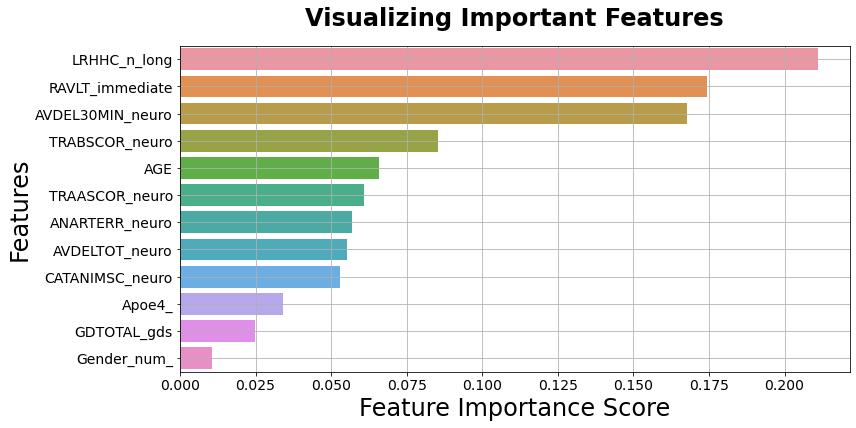

Mean featue importacne plot saved to:
		/home/marek/Dropbox/p1ext4_P/no_work/MCI/MCI-subgroups/results/20210420/3.09_template-TEST-feat-importance-v.png



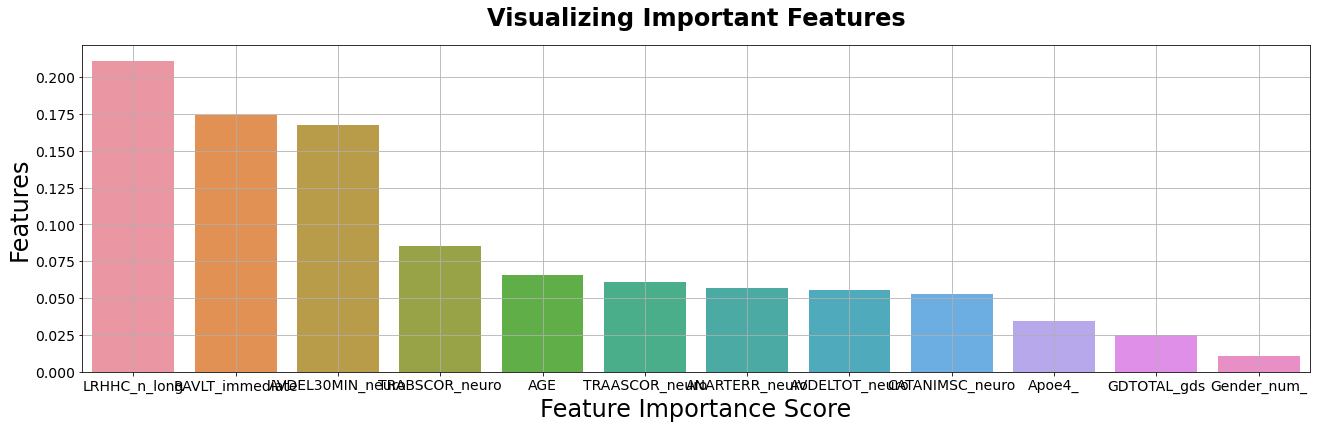

In [53]:
plot_single_feature_importnce(feature_imp, orientation='h', figsize=(12,6))
plot_single_feature_importnce(feature_imp, orientation='v', figsize=(22,6))

---

# FEATURE PERMUTATION

#### SCALED TRAIN SET

In [54]:
perm = PermutationImportance(clf, random_state=42).fit(X_train_scaled, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

#### SCALED TEST SET

In [55]:
perm = PermutationImportance(clf, random_state=42).fit(X_test_scaled, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

# PARTIAL DEPENDENCE PLOTS

#### RESCALE FEATURES TO ABSOLUTE VALUES

In [56]:
def rescale_values_from_std(X):
    """
    C: 2021.05.05 / U: 2021.05.05
    """
    k = np.c_[np.arange(-3,4)]
    f = X.values.mean(axis=0) + k * X.values.std(axis=0)
        
    # when we use the TRAIN SET (scaler)
    # f = scaler.mean_ + k * scaler.scale_
    
    return pd.DataFrame(f, columns=X.columns, index=list(np.squeeze(k).T))    

In [57]:
df_res = rescale_values_from_std(X_test)

#### 1D PDPs

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


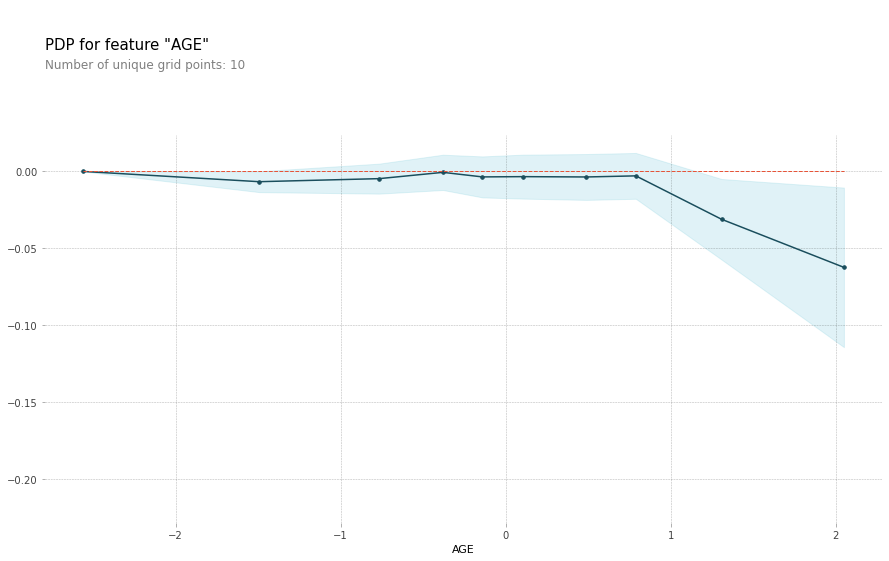

        -3     -2     -1      0      1      2     3
AGE  50.87  58.36  65.85  73.34  80.82  88.31  95.8
------------------------------------------------------------------------------------------


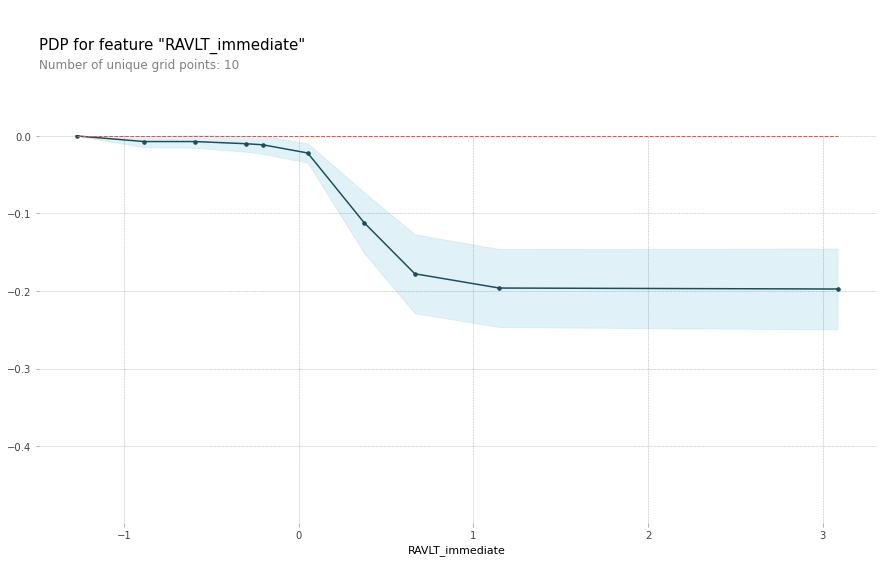

                   -3     -2     -1      0      1      2      3
RAVLT_immediate  7.91  16.61  25.31  34.01  42.72  51.42  60.12
------------------------------------------------------------------------------------------


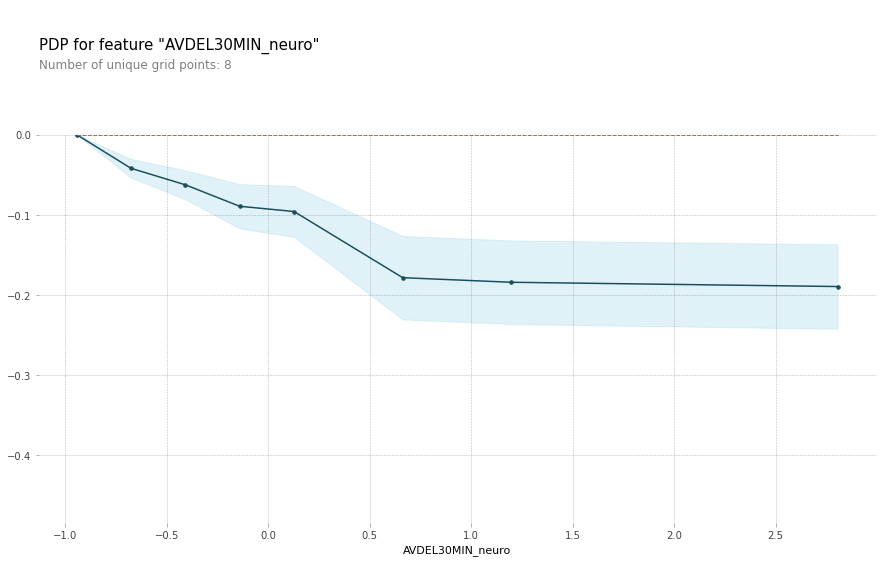

                    -3    -2    -1     0     1      2      3
AVDEL30MIN_neuro -6.61 -3.22  0.18  3.58  6.98  10.38  13.78
------------------------------------------------------------------------------------------


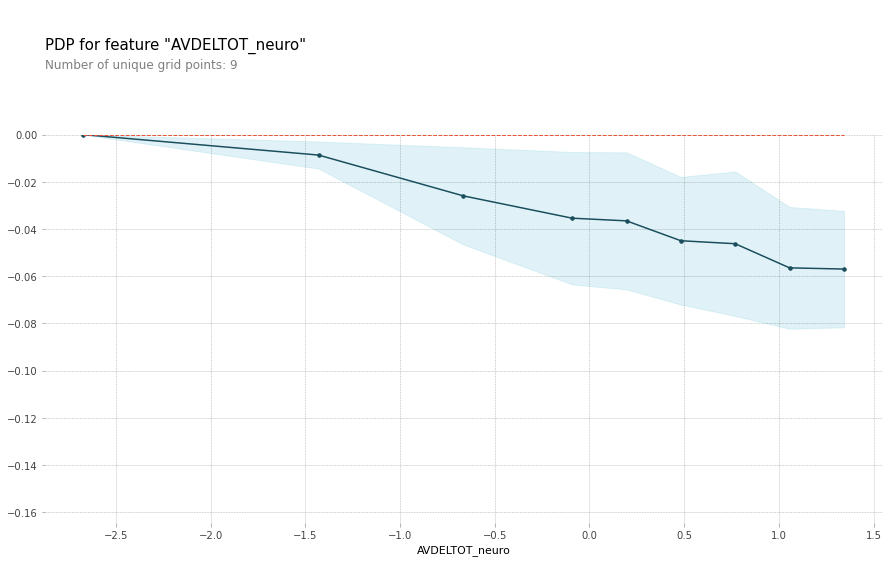

                 -3    -2    -1      0      1      2      3
AVDELTOT_neuro  0.4  3.82  7.23  10.65  14.06  17.48  20.89
------------------------------------------------------------------------------------------


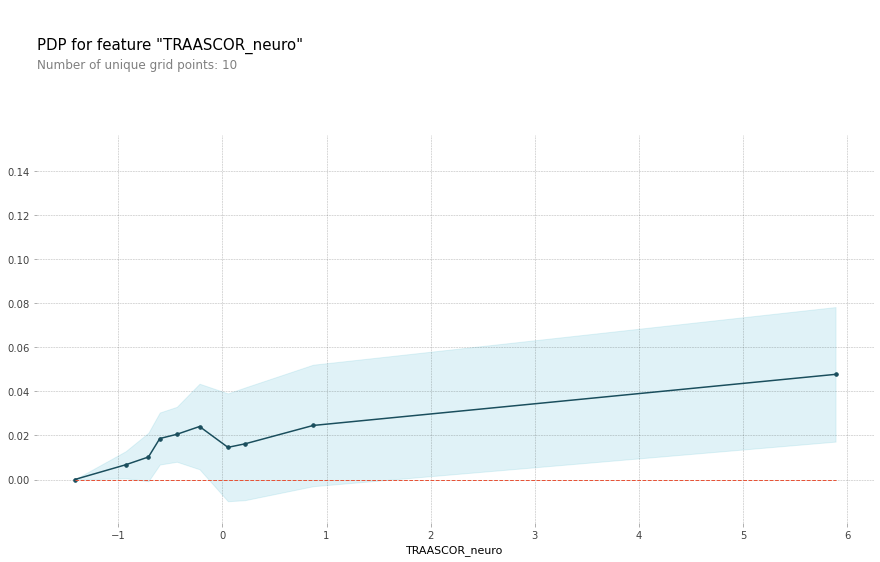

                   -3    -2    -1      0      1      2       3
TRAASCOR_neuro -20.16  0.22  20.6  40.98  61.36  81.74  102.11
------------------------------------------------------------------------------------------


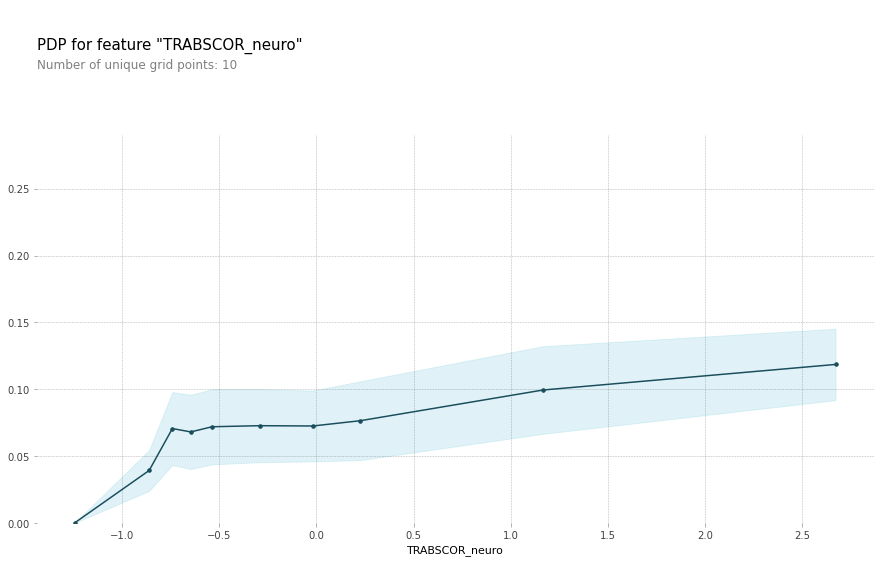

                   -3     -2     -1       0       1       2       3
TRABSCOR_neuro -80.76 -15.06  50.64  116.34  182.04  247.74  313.43
------------------------------------------------------------------------------------------


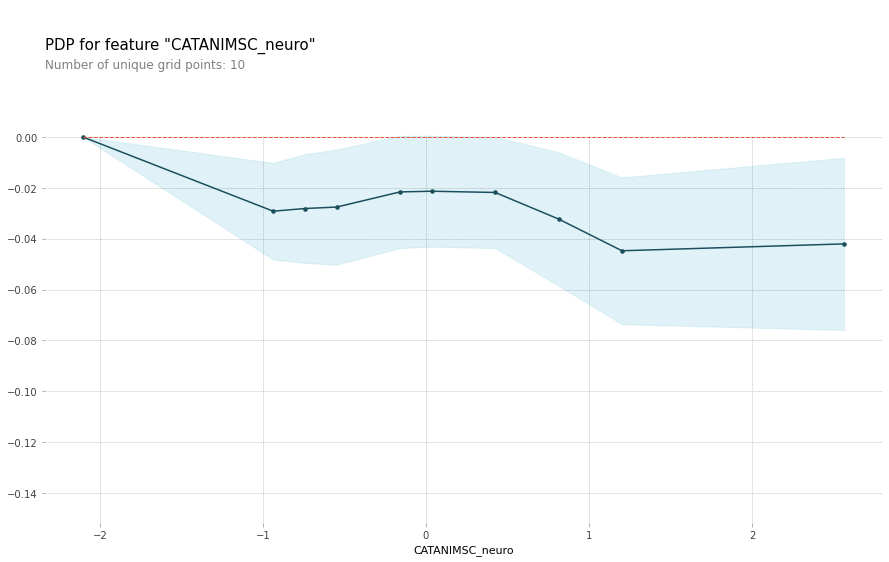

                   -3    -2     -1     0      1      2      3
CATANIMSC_neuro  2.84  7.59  12.35  17.1  21.86  26.61  31.37
------------------------------------------------------------------------------------------


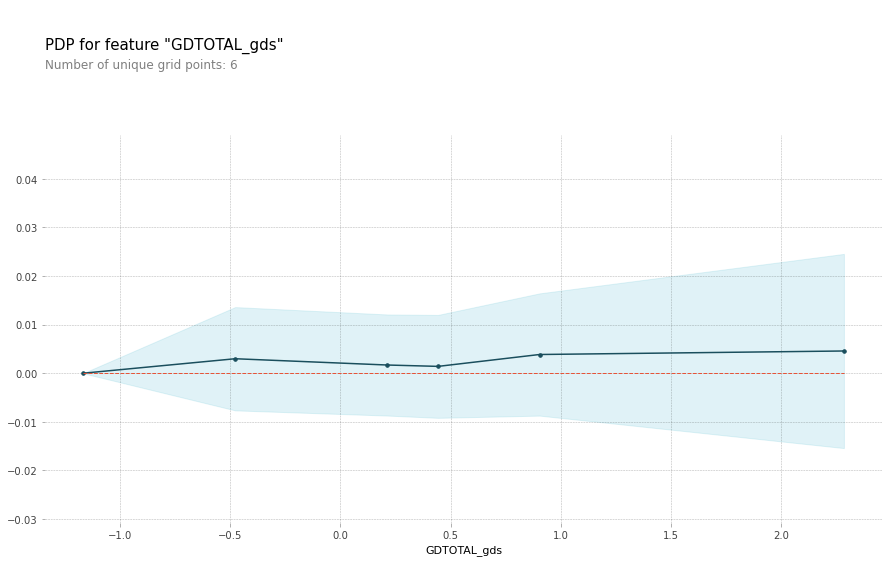

               -3    -2    -1     0     1     2    3
GDTOTAL_gds -2.12 -0.86  0.39  1.64  2.89  4.15  5.4
------------------------------------------------------------------------------------------


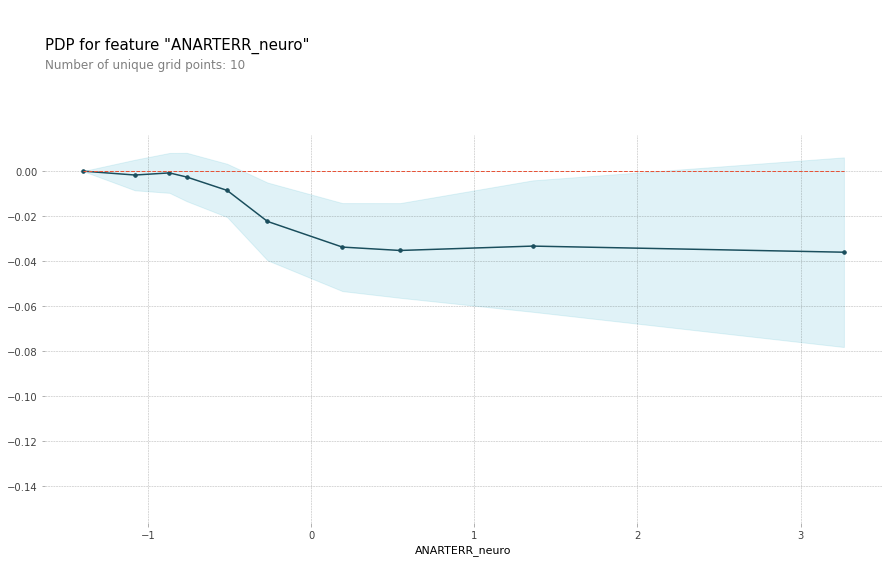

                   -3    -2    -1      0      1     2      3
ANARTERR_neuro -16.21 -6.63  2.95  12.53  22.11  31.7  41.28
------------------------------------------------------------------------------------------


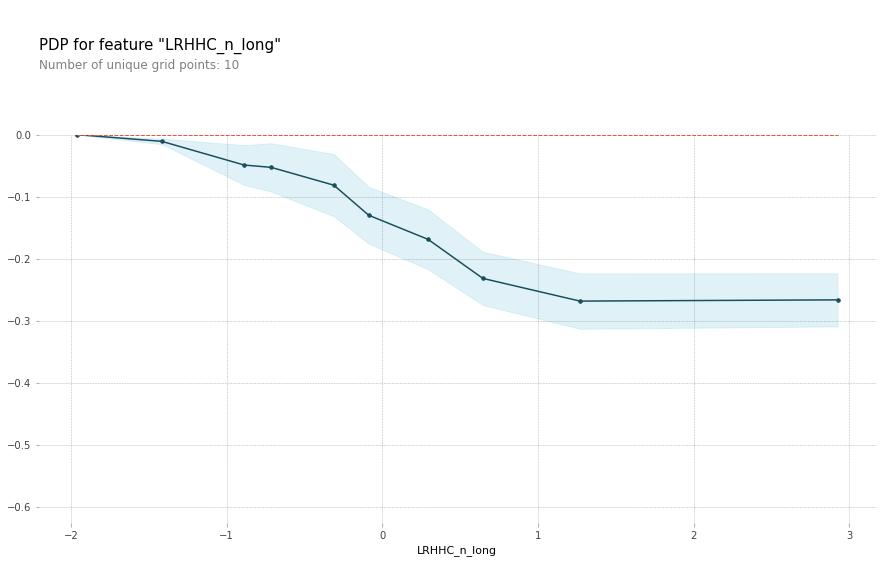

               -3   -2   -1    0    1     2     3
LRHHC_n_long  0.0  0.0  0.0  0.0  0.0  0.01  0.01
------------------------------------------------------------------------------------------


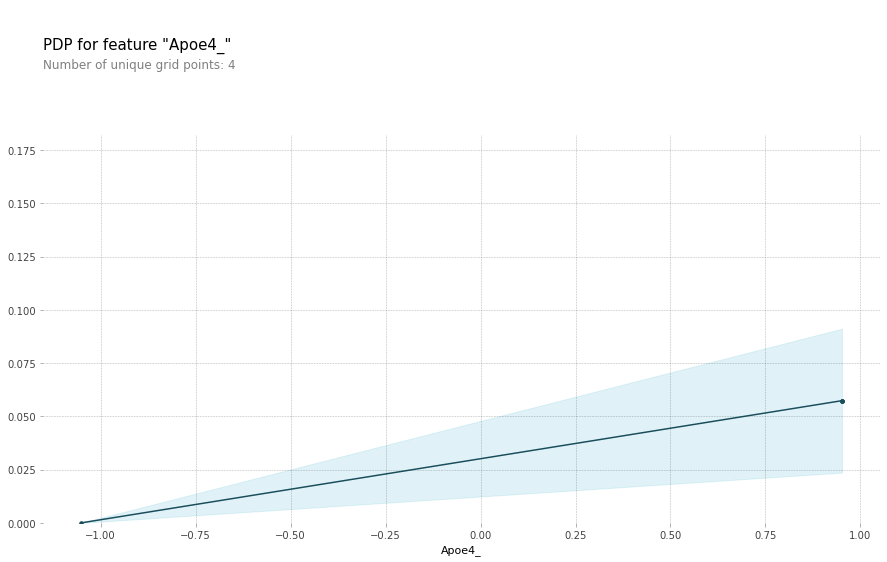

          -3    -2    -1     0     1     2     3
Apoe4_ -0.96 -0.47  0.03  0.53  1.03  1.53  2.03
------------------------------------------------------------------------------------------


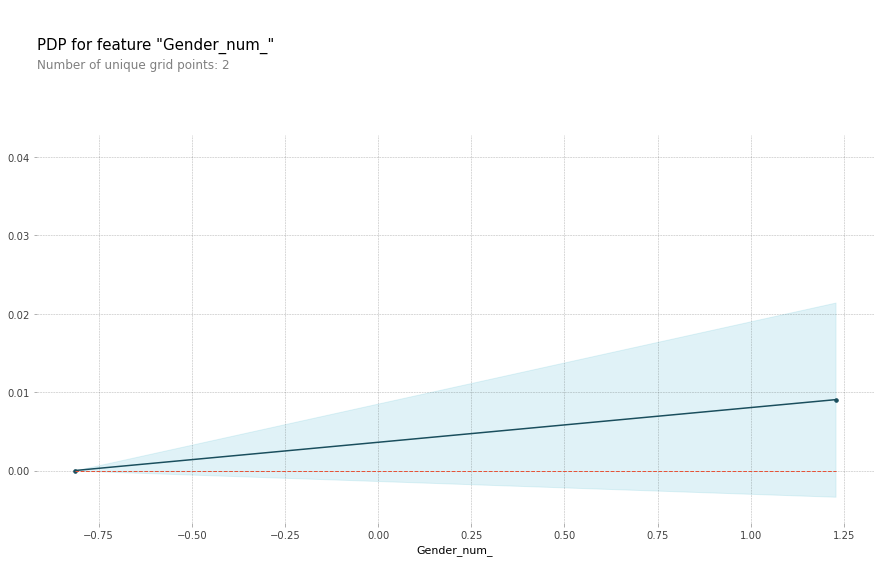

               -3    -2    -1     0    1     2     3
Gender_num_ -1.07 -0.57 -0.08  0.41  0.9  1.39  1.89
------------------------------------------------------------------------------------------


In [58]:
for feature in X_test.columns:
    pdp_goals = pdp.pdp_isolate(model=clf, dataset=X_test_scaled_df,model_features=X_test.columns.tolist(),
                                feature=feature)    
    pdp.pdp_plot(pdp_goals, feature)

    file_name_prefix_ext = f'{file_name_prefix}-pdp-TEST-{feature}.png'
    file_name_prefix_path = RESULTS_DIR / file_name_prefix_ext
    plt.savefig(file_name_prefix_path)

    plt.show()

    # print a table with rescaled values
    print(df_res[feature].round(2).to_frame().T)
    print(90*'-')

#### 2D PDPs

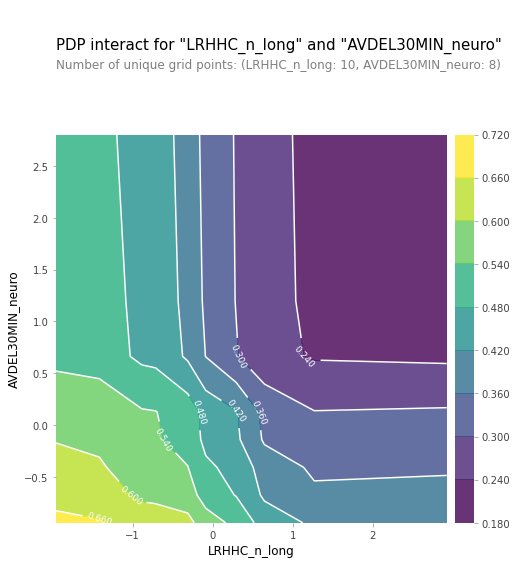

In [59]:
feat = ['LRHHC_n_long', 'AVDEL30MIN_neuro']
interact  =  pdp.pdp_interact(model=clf, dataset=X_test_scaled_df, model_features=X_test_scaled_df.columns.tolist(), features=feat)
pdp.pdp_interact_plot(pdp_interact_out=interact, feature_names=feat, plot_type='contour')
plt.show()

---

---

# PDP AND ICE PLOTS WITH SCIKIT-LEARN ([www](https://scikit-learn.org/stable/modules/partial_dependence.html))

In [60]:
print(features)

['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds', 'ANARTERR_neuro', 'LRHHC_n_long', 'Apoe4_', 'Gender_num_', 'Subgroup_', 'Subgroup_num_', 'Usage_']


#### PARTIAL DEPENDENCE PLOTS  (FEATURES SELECTED BASED ON PDP plot for SCALED TRAIN SET)

CPU times: user 474 ms, sys: 64.6 ms, total: 539 ms
Wall time: 40.9 s


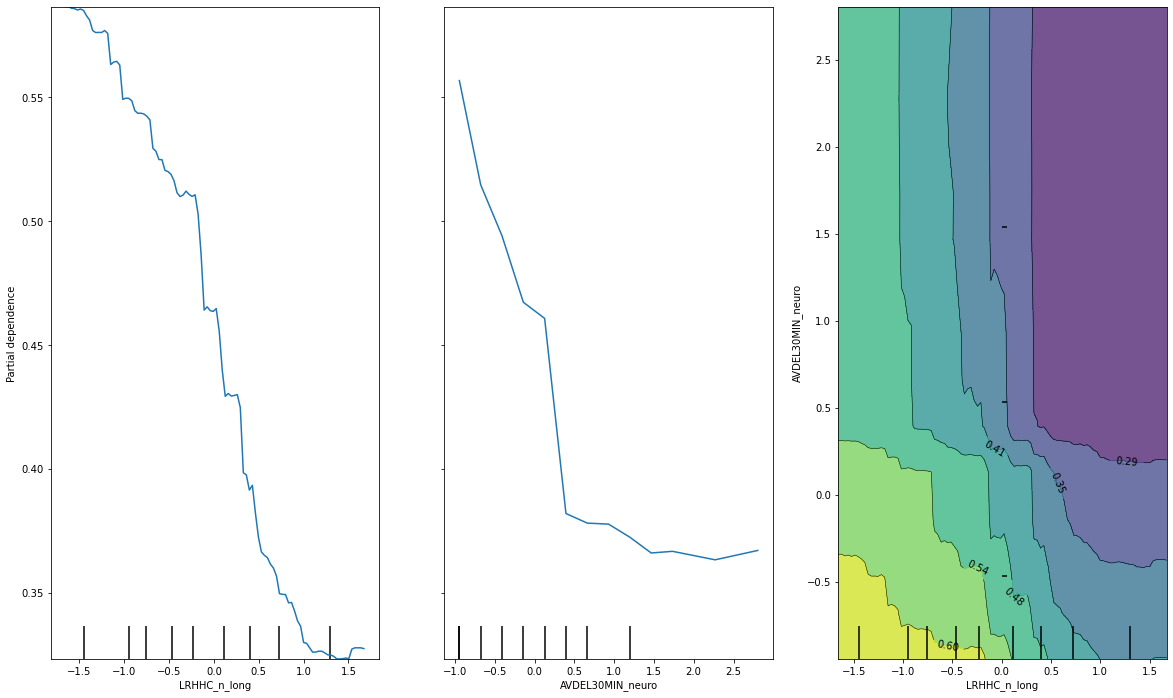

In [61]:
%%time
fig, ax = plt.subplots(figsize=(20,12))
plot_partial_dependence(clf, X_test_scaled_df, ['LRHHC_n_long','AVDEL30MIN_neuro', ('LRHHC_n_long', 'AVDEL30MIN_neuro')], ax=ax, n_jobs=-1)

CPU times: user 415 ms, sys: 4.03 ms, total: 419 ms
Wall time: 2.81 s


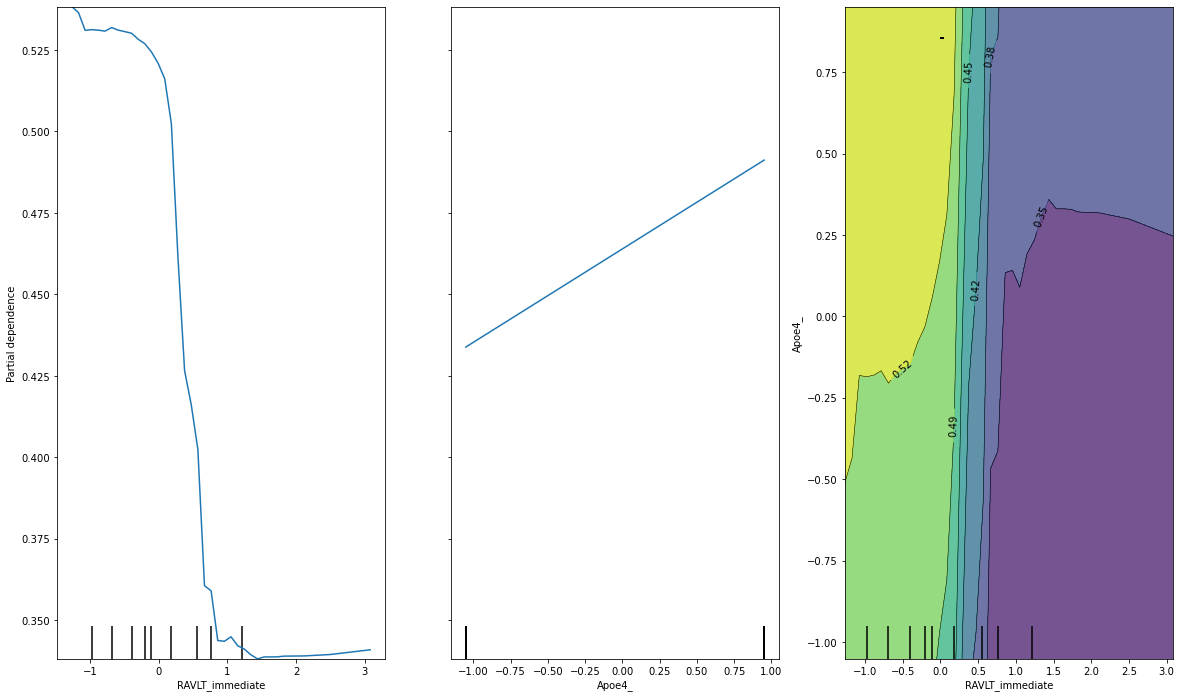

In [62]:
%%time
fig, ax = plt.subplots(figsize=(20,12))
plot_partial_dependence(clf, X_test_scaled_df, ['RAVLT_immediate','Apoe4_', ('RAVLT_immediate', 'Apoe4_')], ax=ax, n_jobs=-1)

CPU times: user 376 ms, sys: 153 µs, total: 376 ms
Wall time: 6.09 s


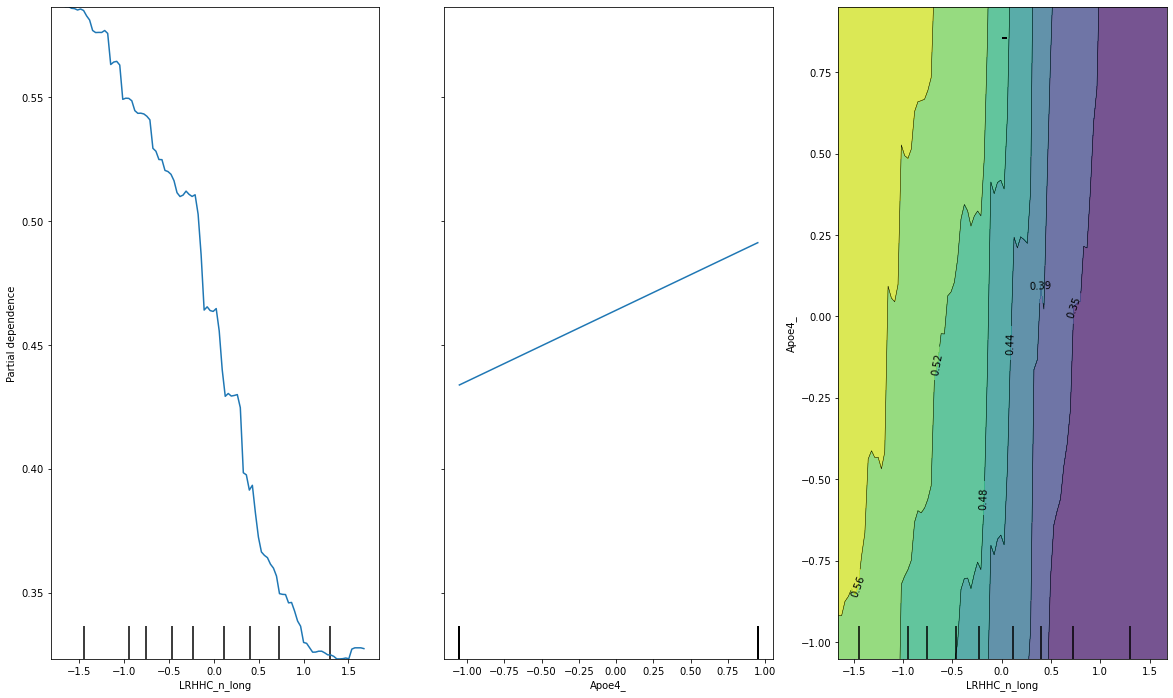

In [63]:
%%time
fig, ax = plt.subplots(figsize=(20,12))
plot_partial_dependence(clf, X_test_scaled_df, ['LRHHC_n_long','Apoe4_', ('LRHHC_n_long', 'Apoe4_')], ax=ax, n_jobs=-1)

CPU times: user 385 ms, sys: 307 µs, total: 386 ms
Wall time: 1min 41s


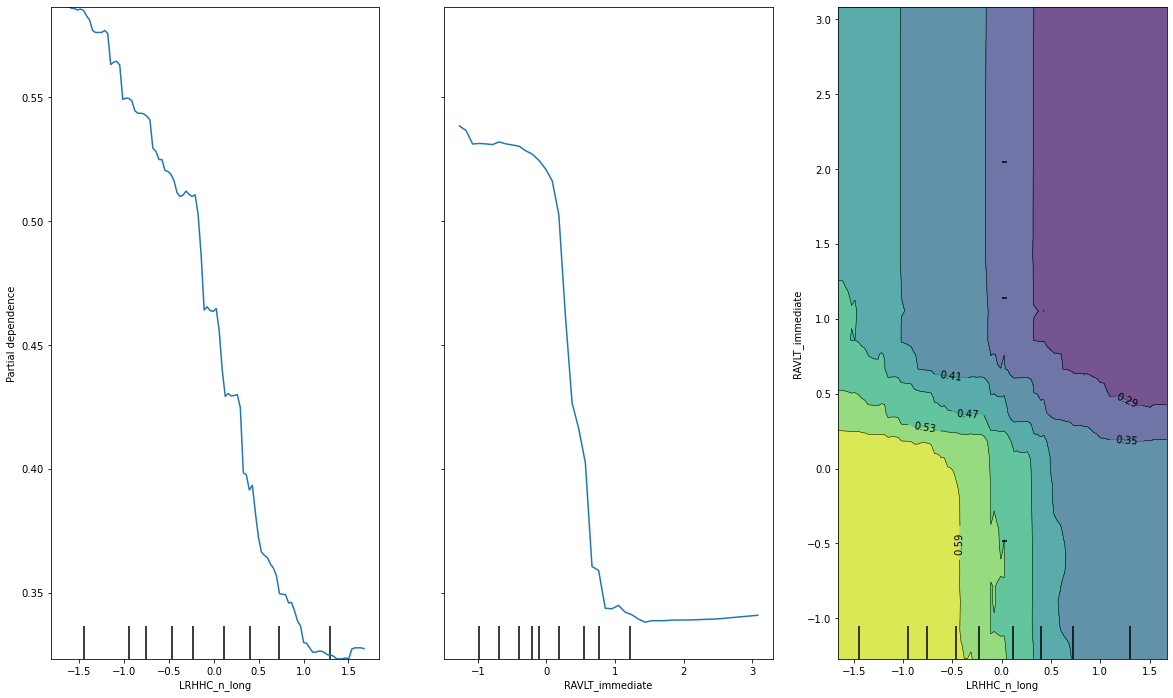

In [64]:
%%time
fig, ax = plt.subplots(figsize=(20,12))
plot_partial_dependence(clf, X_test_scaled_df, ['LRHHC_n_long','RAVLT_immediate', ('LRHHC_n_long', 'RAVLT_immediate')], ax=ax, n_jobs=-1)

CPU times: user 429 ms, sys: 4.27 ms, total: 433 ms
Wall time: 14.5 s


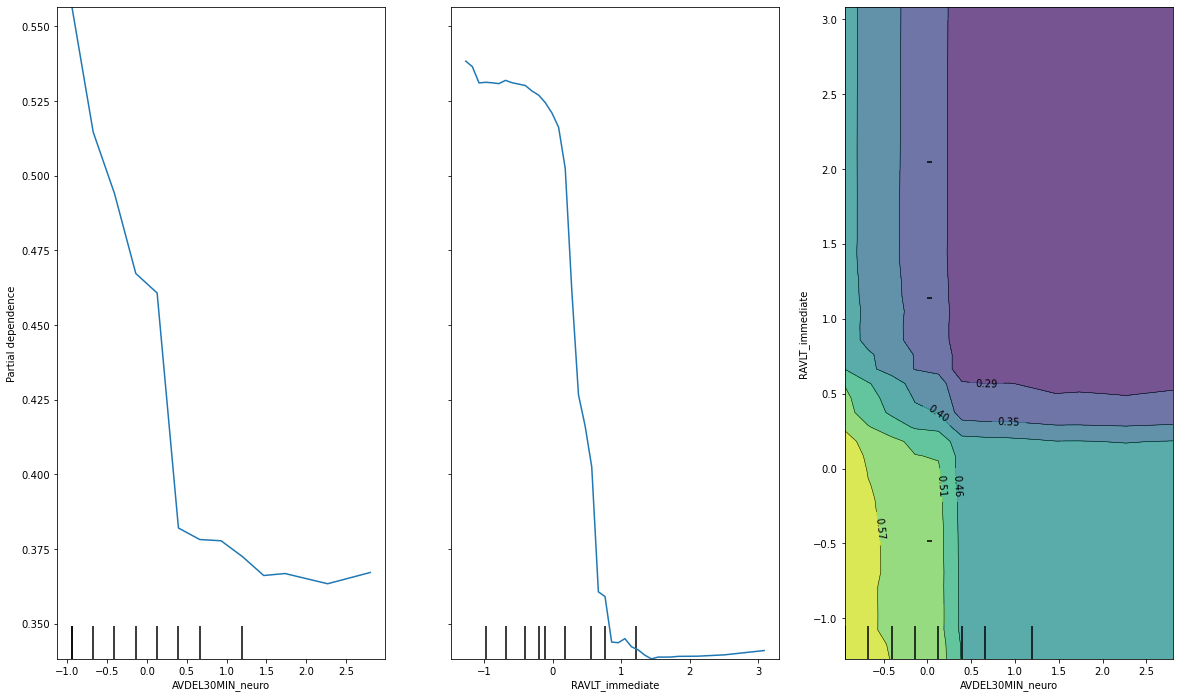

In [65]:
%%time
fig, ax = plt.subplots(figsize=(20,12))
plot_partial_dependence(clf, X_test_scaled_df, ['AVDEL30MIN_neuro','RAVLT_immediate', ('AVDEL30MIN_neuro', 'RAVLT_immediate')], ax=ax, n_jobs=-1)

CPU times: user 403 ms, sys: 4.22 ms, total: 407 ms
Wall time: 1.29 s


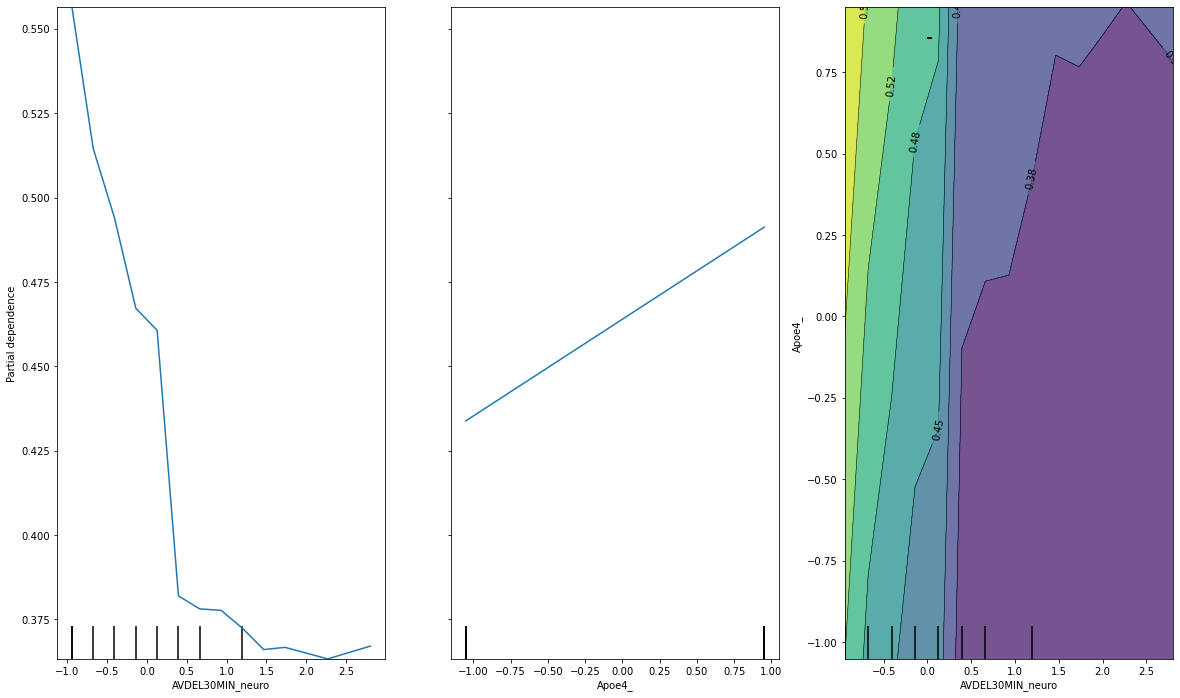

In [66]:
%%time
fig, ax = plt.subplots(figsize=(20,12))
plot_partial_dependence(clf, X_test_scaled_df, ['AVDEL30MIN_neuro','Apoe4_', ('AVDEL30MIN_neuro', 'Apoe4_')], ax=ax, n_jobs=-1)

#### INDIVIDUAL CONDITIONAL EXPECTATION (ICE) PLOTS - SCALED TRAIN SET

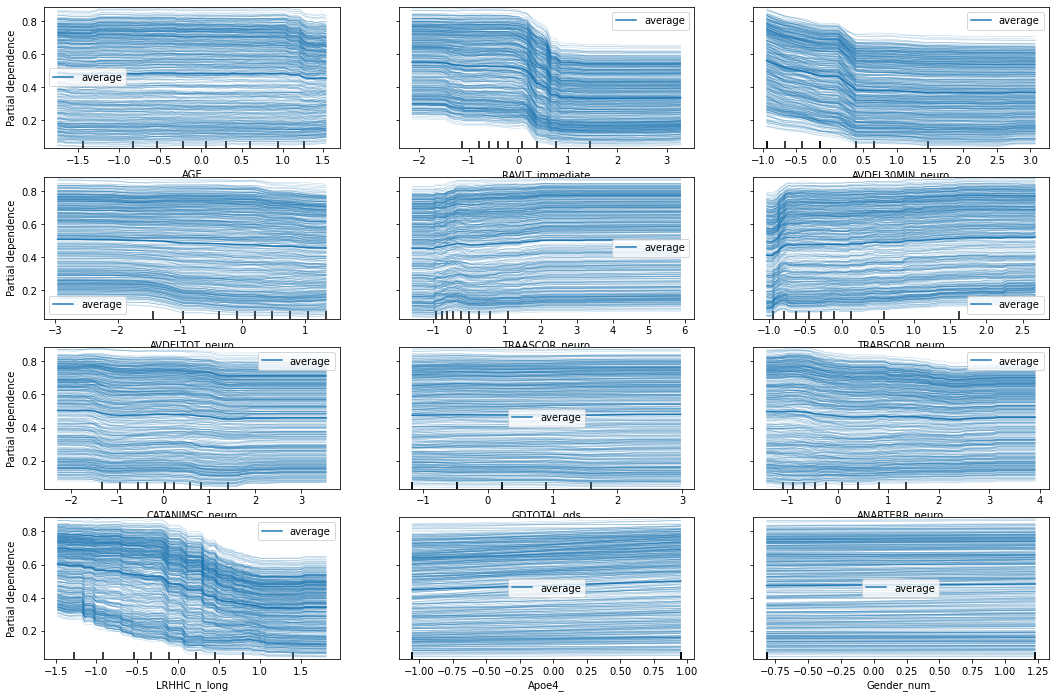

In [67]:
fig,ax = plt.subplots(figsize=(18,12),)
_=plot_partial_dependence(clf, X_train_scaled, features=X_train_scaled.columns, kind='both', ax=ax)

#### INDIVIDUAL CONDITIONAL EXPECTATION (ICE) PLOTS - SCALED TEST SET

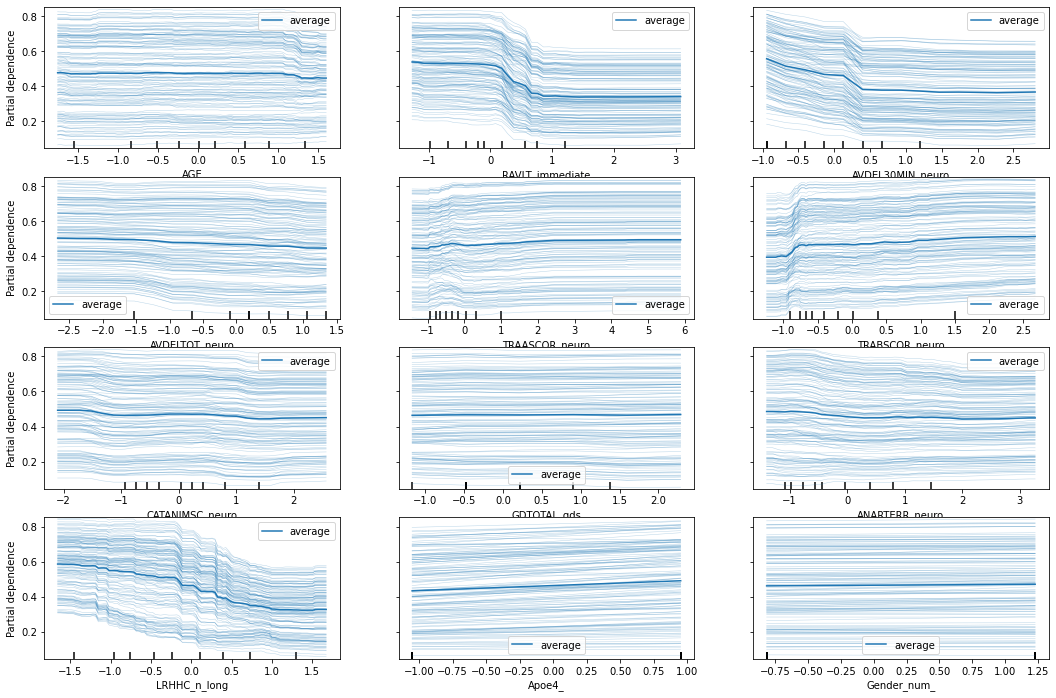

In [68]:
fig,ax = plt.subplots(figsize=(18,12))
_=plot_partial_dependence(clf, X_test_scaled_df, features=X_test_scaled_df.columns, kind='both', ax=ax)

---